## Problem Approach

1. We filtered the data based on high valued customer as described in problem statement, for this we did missing value treatment in the 'data' fields assuming that no recharge has been done in missing value hence imputed with 0
2. Add the churn variable based on no usage on September month
3. Added few derived variables
4. Dropped the columns having same values and having different values (categorical) like mobile number, circle number etc
5. Standardized the date into datetime format
6. Missing value treatment 
    a. Created IsRecharge done if the last recharge date is null
    b. We imputed 0 assuming there is no recharge done, to those fields where  min is 0 or 1
    c. We divided arpu fields wrt Churn and imputed missing value with its class median
7. Exploratory Data Analysis
    a. Heavy class imbalance was observed only 8%  data was churn data
    b. High correlation was observed in few variables
    c. Outlier Detection and removal of outlier more than 99 percentile, removing 5% of upper outliers
    d. Customers are taking min 180 days before moving out of the network
8. Model Building
    a. Split data for train and test.
    b. Handled class imbalance using SMOTE
    c. Rescaling using MinMax Scaler
    d. Logistic Regression using RFE
    e. PCA
    f. Logistic Regression using PCA 
    g. Decision Tree
    h. SVM using PCA
    i. Random Forest
    j. Ada Boost
    h. XGBoost
9. Model Selection
10. Conclusion
    
    
    

In [159]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics

%matplotlib inline

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [160]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None 

In [161]:
raw_df =pd.read_csv('telecom_churn_data.csv')
df=raw_df

Filter the data based on Recharge Amount

In [162]:
raw_df=df
print(raw_df.shape)

(99999, 226)


### Filtering High Value Customer

Calculating the mean recharge amount done in good months and filtering customers who are recharging more than 70 percentile

Imputing 0 for  `['total_rech_amt_6','total_rech_data_6','av_rech_amt_data_6','total_rech_amt_7','total_rech_data_7','av_rech_amt_data_7']` assuming if the data is missing no recharge has been done 

In [163]:
raw_df[['total_rech_amt_6','total_rech_data_6','av_rech_amt_data_6','total_rech_amt_7','total_rech_data_7','av_rech_amt_data_7']]=raw_df[['total_rech_amt_6','total_rech_data_6','av_rech_amt_data_6','total_rech_amt_7','total_rech_data_7','av_rech_amt_data_7']].fillna(0)
raw_df[['total_rech_amt_6','total_rech_data_6','av_rech_amt_data_6','total_rech_amt_7','total_rech_data_7','av_rech_amt_data_7']].describe()

total_rech_amt_6  total_rech_data_6  av_rech_amt_data_6  \
count      99999.000000       99999.000000        99999.000000   
mean         327.514615           0.619726           48.445409   
std          398.019701           1.760541          127.743863   
min            0.000000           0.000000            0.000000   
25%          109.000000           0.000000            0.000000   
50%          230.000000           0.000000            0.000000   
75%          437.500000           1.000000            8.250000   
max        35190.000000          61.000000         7546.000000   

       total_rech_amt_7  total_rech_data_7  av_rech_amt_data_7  
count      99999.000000       99999.000000        99999.000000  
mean         322.962970           0.681837           51.393440  
std          408.114237           1.924382          132.629365  
min            0.000000           0.000000            0.000000  
25%          100.000000           0.000000            0.000000  
50%          220.000000           0.000000            0.000000  
75%          428.000000           1.000000           17.000000  
max        40335.000000          54.000000         4365.000000

In [164]:

raw_df['total_rech_6'] = raw_df['total_rech_amt_6'] + (raw_df['total_rech_data_6']*raw_df['av_rech_amt_data_6'])
raw_df['total_rech_7'] = raw_df['total_rech_amt_7'] + (raw_df['total_rech_data_7']*raw_df['av_rech_amt_data_7'])
# raw_df['total_rech_8'] = raw_df['total_rech_amt_8'] + (raw_df['total_rech_data_8']*raw_df['av_rech_amt_data_8'])
# raw_df['total_rech_9'] = raw_df['total_rech_amt_9'] + (raw_df['total_rech_data_9']*raw_df['av_rech_amt_data_9'])
raw_df['total_rech_good_mean']=raw_df[['total_rech_6','total_rech_7']].mean(axis=1)

p70=raw_df['total_rech_good_mean'].quantile(.7)
print('70 percentile of first two months avg recharge amount: ', p70)


70 percentile of first two months avg recharge amount:  478.0


In [165]:
raw_df['total_rech_good_mean'].describe()

count    99999.000000
mean       485.328068
std        869.423594
min          0.000000
25%        128.000000
50%        275.000000
75%        553.000000
max      61236.000000
Name: total_rech_good_mean, dtype: float64

In [166]:
telecom = raw_df[raw_df['total_rech_good_mean']>=p70]
telecom.shape
print('Dataframe Shape: ', telecom.shape)


Dataframe Shape:  (30001, 229)


### Creating Derived Variables

### Adding Churn Variable

In [167]:
telecom['isChurn'] = np.where(((telecom['total_ic_mou_9']==0) & (telecom['total_og_mou_9']==0) & (telecom['vol_2g_mb_9']==0) & (telecom['vol_3g_mb_9']==0)),1,0)

In [168]:
telecom['total_rech_data_amt_6'] = telecom['total_rech_data_6']*telecom['av_rech_amt_data_6']
telecom['total_rech_data_amt_7'] = telecom['total_rech_data_7']*telecom['av_rech_amt_data_7']
telecom['total_rech_data_amt_8'] = telecom['total_rech_data_8']*telecom['av_rech_amt_data_8']

telecom['total_rech_8'] = telecom['total_rech_amt_8'] + telecom['total_rech_data_amt_8']
telecom.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'], axis=1, inplace=True)

telecom['vol_data_mb_6']=telecom['vol_2g_mb_6']+telecom['vol_3g_mb_6']
telecom['vol_data_mb_7']=telecom['vol_2g_mb_7']+telecom['vol_3g_mb_7']
telecom['vol_data_mb_8']=telecom['vol_2g_mb_8']+telecom['vol_3g_mb_8']
telecom.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_2g_mb_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','vol_3g_mb_9'], axis=1, inplace=True)


telecom['count_rech_data_6']=telecom['count_rech_2g_6'] + telecom['count_rech_3g_6'] 
telecom['count_rech_data_7']=telecom['count_rech_2g_7'] + telecom['count_rech_3g_7'] 
telecom['count_rech_data_8']=telecom['count_rech_2g_8'] + telecom['count_rech_3g_8'] 
telecom.drop(['count_rech_2g_6', 'count_rech_2g_7' , 'count_rech_2g_8' , 'count_rech_2g_9' , 'count_rech_3g_6' , 'count_rech_3g_7' , 'count_rech_3g_8' , 'count_rech_3g_9' ], axis=1, inplace=True)

telecom['arpu_data_6'] = telecom['arpu_2g_6'] + telecom['arpu_3g_6']
telecom['arpu_data_7'] = telecom['arpu_2g_7'] + telecom['arpu_3g_7']
telecom['arpu_data_8'] = telecom['arpu_2g_8'] + telecom['arpu_3g_8']
telecom.drop(['arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9','arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_2g_9'], axis=1, inplace=True)


# Renaming the following columns to follow the naming conventions `jul_vbc_3g, jun_vbc_3g, sep_vbc_3g` 
telecom['vbc_3g_6'] = telecom['jun_vbc_3g']
telecom['vbc_3g_7'] = telecom['jul_vbc_3g']
telecom['vbc_3g_8'] = telecom['aug_vbc_3g']
telecom['vbc_3g_9'] = telecom['sep_vbc_3g']

# Dropping all ninth month features
col = list(telecom.columns)
c9=[]
j=1
for i in col:
    if '_9' in i:
       c9.append(i)
       j=j+1
telecom.drop(c9, axis=1, inplace=True)
telecom.drop(['jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g','aug_vbc_3g'], axis=1, inplace=True)





In [169]:
telecom.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 164 columns):
mobile_number               int64
circle_id                   int64
loc_og_t2o_mou              float64
std_og_t2o_mou              float64
loc_ic_t2o_mou              float64
last_date_of_month_6        object
last_date_of_month_7        object
last_date_of_month_8        object
arpu_6                      float64
arpu_7                      float64
arpu_8                      float64
onnet_mou_6                 float64
onnet_mou_7                 float64
onnet_mou_8                 float64
offnet_mou_6                float64
offnet_mou_7                float64
offnet_mou_8                float64
roam_ic_mou_6               float64
roam_ic_mou_7               float64
roam_ic_mou_8               float64
roam_og_mou_6               float64
roam_og_mou_7               float64
roam_og_mou_8               float64
loc_og_t2t_mou_6            float64
loc_og_t2t_mou_7            float

In [170]:
unique_val_cols = telecom.nunique()
single_valued_columns = unique_val_cols[unique_val_cols==1]
unique_valued_columns = unique_val_cols[unique_val_cols==len(telecom.index)]
categorical_valued_columns = unique_val_cols[(unique_val_cols==2)]
categorical_valued_columns.drop('isChurn', inplace=True)
categorical_valued_columns

night_pck_user_6    2
night_pck_user_7    2
night_pck_user_8    2
fb_user_6           2
fb_user_7           2
fb_user_8           2
dtype: int64

### Drop Columns 
1. with single value data
2. with all unique data

In [171]:
telecom.drop(single_valued_columns.index, axis=1, inplace=True)
telecom.drop(unique_valued_columns.index, axis=1, inplace=True)




### Treatement of Categorical Variable


In [172]:
# telecom[categorical_valued_columns.index].head(200)

# categorical_map = {1.0: 'Yes' , 0.0:'No' , np.nan: }
# (categorical_map)

telecom[categorical_valued_columns.index]=telecom[categorical_valued_columns.index].fillna(0)

#telecom[categorical_valued_columns.index] = pd.get_dummies(telecom[categorical_valued_columns.index], drop_first=True)


### Standardize the Date

In [173]:
cdate=list(filter(lambda x: 'date' in x,telecom.columns))
telecom[cdate]=telecom[cdate].apply(lambda x: pd.to_datetime(x,format ='%m/%d/%Y'))
# telecom[cdate]=telecom[cdate].applymap(lambda s: s.split('/')[1] if type(s)==str else s)
# telecom[cdate].head(100)

In [174]:
missing_col_info = round(telecom.isnull().sum()/len(telecom.index) * 100,2) 
print(missing_col_info[missing_col_info>20])

# telecom.isnull().sum(axis=1)
display(telecom[missing_col_info[missing_col_info>10].index].describe())
telecom[missing_col_info[missing_col_info>10].index].head()

date_of_last_rech_data_6    44.15
date_of_last_rech_data_7    43.15
date_of_last_rech_data_8    46.83
max_rech_data_6             44.15
max_rech_data_7             43.15
max_rech_data_8             46.83
total_rech_data_amt_8       46.83
total_rech_8                46.83
count_rech_data_6           44.15
count_rech_data_7           43.15
count_rech_data_8           46.83
arpu_data_6                 44.15
arpu_data_7                 43.15
arpu_data_8                 46.83
dtype: float64


max_rech_data_6  max_rech_data_7  max_rech_data_8  \
count     16756.000000     17057.000000     15953.000000   
mean        139.798580       140.431143       136.329217   
std         118.851784       120.247247       119.531924   
min           1.000000         1.000000         1.000000   
25%          25.000000        25.000000        25.000000   
50%         152.000000       152.000000       152.000000   
75%         198.000000       198.000000       198.000000   
max        1555.000000      1555.000000      1555.000000   

       total_rech_data_amt_8  total_rech_8  count_rech_data_6  \
count           15953.000000  15953.000000       16756.000000   
mean              871.187336   1473.666493           2.985975   
std              2144.065234   2303.261744           3.227379   
min                 1.000000     23.000000           1.000000   
25%               154.000000    566.000000           1.000000   
50%               252.000000    936.000000           2.000000   
75%               861.000000   1620.000000           4.000000   
max             89106.500000  95884.500000          61.000000   

       count_rech_data_7  count_rech_data_8   arpu_data_6   arpu_data_7  \
count       17057.000000       15953.000000  16756.000000  17057.000000   
mean            3.260597           3.050147    233.560555    234.497036   
std             3.496721           3.538953    420.612202    427.819705   
min             1.000000           1.000000    -30.280000    -26.040000   
25%             1.000000           1.000000      1.067500      0.930000   
50%             2.000000           2.000000     50.665000     46.720000   
75%             4.000000           4.000000    339.002500    338.800000   
max            54.000000          60.000000  12796.040000   9790.260000   

        arpu_data_8  
count  15953.000000  
mean     227.868400  
std      406.889975  
min      -24.490000  
25%        0.380000  
50%       40.900000  
75%      328.270000  
max     6934.350000

date_of_last_rech_data_6 date_of_last_rech_data_7 date_of_last_rech_data_8  \
0                2014-06-21               2014-07-16               2014-08-08   
7                       NaT                      NaT                      NaT   
8                       NaT               2014-07-31               2014-08-23   
21                      NaT                      NaT                      NaT   
23                      NaT               2014-07-07               2014-08-06   

    max_rech_data_6  max_rech_data_7  max_rech_data_8  total_rech_data_amt_8  \
0             252.0            252.0            252.0                  252.0   
7               NaN              NaN              NaN                    NaN   
8               NaN            154.0             23.0                  207.0   
21              NaN              NaN              NaN                    NaN   
23              NaN            179.0            179.0                  540.0   

    total_rech_8  count_rech_data_6  count_rech_data_7  count_rech_data_8  \
0          504.0                1.0                1.0                1.0   
7            NaN                NaN                NaN                NaN   
8          327.0                NaN                2.0                3.0   
21           NaN                NaN                NaN                NaN   
23         979.0                NaN                2.0                2.0   

    arpu_data_6  arpu_data_7  arpu_data_8  
0        424.34       424.34       424.34  
7           NaN          NaN          NaN  
8           NaN         0.00        19.83  
21          NaN          NaN          NaN  
23          NaN       608.35       347.94

The absence of the date value for any customer refer that the customer has not recharged on that particular month, Lets create a new derived column as whether the customer has recharged on this month or not, as we are not doing much with the date column anyways

In [175]:
date_cols=['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8',
           'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
out_date=list(map(lambda x: x.replace('date_of_',''),date_cols))

telecom[out_date]=telecom[date_cols].applymap(lambda x: -1 if pd.isnull(x) else 1)
telecom.drop(date_cols, axis=1, inplace=True)

Analysing arpu columns wrt Churn

In [176]:
missing_col_info = round(telecom.isnull().sum()/len(telecom.index) * 100,2) 
print(missing_col_info[missing_col_info>20])

# telecom.isnull().sum(axis=1)
#display(telecom[missing_col_info[missing_col_info>10].index].describe())
arpu_col = list(missing_col_info[missing_col_info>10].index)
arpu_col.append('isChurn')
print(arpu_col)
arpu_churn_df=telecom[arpu_col]

arpu_g_df=arpu_churn_df.groupby('isChurn').median()
#arpu_g_df.reset_index(inplace=True)
di_0 = {'arpu_data_6' : arpu_g_df['arpu_data_6'][0],'arpu_data_7' : arpu_g_df['arpu_data_7'][0],'arpu_data_8' : arpu_g_df['arpu_data_8'][0]}
di_1 = {'arpu_data_6' : arpu_g_df['arpu_data_6'][1],'arpu_data_7' : arpu_g_df['arpu_data_7'][1],'arpu_data_8' : arpu_g_df['arpu_data_8'][1]}

#arpu_churn_df.info()
# telecom['arpu_data_6'].fillna()
#Lets Impute the Median value of each class into the arpu values of each month
# print(arpu_churn_df.info())
arpu_churn_df[arpu_churn_df['isChurn']==0]=arpu_churn_df[arpu_churn_df['isChurn']==0].fillna(di_0)
arpu_churn_df[arpu_churn_df['isChurn']==1]=arpu_churn_df[arpu_churn_df['isChurn']==1].fillna(di_1)

arpu_col.remove('isChurn')
telecom[arpu_col]=arpu_churn_df[arpu_col]
del arpu_churn_df ,arpu_g_df 


max_rech_data_6          44.15
max_rech_data_7          43.15
max_rech_data_8          46.83
total_rech_data_amt_8    46.83
total_rech_8             46.83
count_rech_data_6        44.15
count_rech_data_7        43.15
count_rech_data_8        46.83
arpu_data_6              44.15
arpu_data_7              43.15
arpu_data_8              46.83
dtype: float64
['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'total_rech_data_amt_8', 'total_rech_8', 'count_rech_data_6', 'count_rech_data_7', 'count_rech_data_8', 'arpu_data_6', 'arpu_data_7', 'arpu_data_8', 'isChurn']


 In these columns we can impute null as 0 as the min recharge value is 1, the null represents No recharge is done  `max_rech_data_6,max_rech_data_7,max_rech_data_8,total_rech_data_amt_8,total_rech_8,
 count_rech_data_6,count_rech_data_7,count_rech_data_8`


In [177]:
telecom[['max_rech_data_6','max_rech_data_7', 
         'max_rech_data_8','total_rech_data_amt_8',
         'total_rech_8','count_rech_data_6',
         'count_rech_data_7','count_rech_data_8']] = telecom[['max_rech_data_6','max_rech_data_7',
                                                              'max_rech_data_8','total_rech_data_amt_8','total_rech_8',
                                                              'count_rech_data_6','count_rech_data_7', 
                                                              'count_rech_data_8']].fillna(0)




In [178]:
missing_col_info = round(telecom.isnull().sum()/len(telecom.index) * 100,2) 
telecom[missing_col_info[missing_col_info>0.5].index].describe()

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  29456.000000  29464.000000  28827.000000  29456.000000  29464.000000   
mean     265.618262    272.700470    243.646938    380.608111    384.994337   
std      462.493645    482.972367    465.200856    484.257474    500.807874   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       19.240000     18.155000     14.255000     78.575000     76.040000   
50%       88.060000     86.885000     72.930000    229.635000    227.120000   
75%      297.415000    298.087500    255.025000    494.780000    500.365000   
max     7376.710000   8157.780000  10752.560000   8362.360000   9667.130000   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  28827.000000   29456.000000   29464.000000   28827.000000   
mean     348.723294      16.408431      12.872921      13.009645   
std      486.918550      76.973057      76.454034      75.575865   
min        0.000000       0.000000       0.000000       0.000000   
25%       58.670000       0.000000       0.000000       0.000000   
50%      197.590000       0.000000       0.000000       0.000000   
75%      455.385000       0.000000       0.000000       0.000000   
max    14007.340000    2613.310000    3813.290000    4169.810000   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
count   29456.000000   29464.000000   28827.000000      29456.000000   
mean       27.063178      20.519370      20.674656         86.047905   
std       117.218920      96.933381     106.751862        230.609510   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          5.030000   
50%         0.000000       0.000000       0.000000         25.580000   
75%         0.000000       0.000000       0.000000         79.765000   
max      3775.110000    2812.040000    5337.040000       6431.330000   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count      29464.000000      28827.000000      29456.000000      29464.000000   
mean          87.235755         81.256858        166.263652        165.980922   
std          242.427257        231.399901        251.423301        242.754684   
min            0.000000          0.000000          0.000000          0.000000   
25%            5.280000          3.830000         21.137500         22.910000   
50%           25.780000         23.240000         80.240000         81.685000   
75%           80.282500         76.040000        212.417500        211.745000   
max         7400.660000      10752.560000       4729.740000       4557.140000   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
count      28827.000000      29456.000000      29464.000000      28827.000000   
mean         157.937216          6.461494          6.540759          6.126112   
std          236.315181         22.310305         22.125961         19.858510   
min            0.000000          0.000000          0.000000          0.000000   
25%           17.530000          0.000000          0.000000          0.000000   
50%           74.540000          0.110000          0.210000          0.000000   
75%          205.860000          4.390000          4.540000          4.260000   
max         4961.330000       1466.030000       1196.430000        928.490000   

       loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
count      29456.000000      29464.000000      28827.000000  29456.000000   
mean           1.604247          1.924320          1.777295    258.781428   
std            6.357757          9.238487          7.345047    380.226723   
min            0.000000          0.000000          0.000000      0.000000   
25%            0.000000          0.000000          0.000000     35.987500   
50%            0.000000          0.000000          0.000000    129.350000   
75%            0.000000          0.

As we can see that min is 0 for all these columns, lets impute 0

In [179]:
telecom[missing_col_info[missing_col_info>0.5].index]=telecom[missing_col_info[missing_col_info>0.5].index].fillna(0)
# df9=filt_df[c9]
# telecom.drop(c9,axis=1,inplace=True)
# df9.head()

In [180]:
missing_col_info = round(telecom.isnull().sum()/len(telecom.index) * 100,2) 
print(missing_col_info[missing_col_info>0.01])
print("Now we don't have any more missing values")

Series([], dtype: float64)
Now we don't have any more missing values


## Exploratory Data Analysis

In [181]:
telecom.describe()

arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  30001.000000  30001.000000  30001.000000  30001.000000  30001.000000   
mean     558.490824    560.782203    508.597957    260.793024    267.819295   
std      460.640461    479.776947    501.961981    459.644368    479.993989   
min    -2258.709000  -2014.045000   -945.808000      0.000000      0.000000   
25%      309.865000    309.826000    231.473000     17.080000     16.030000   
50%      481.694000    480.943000    427.585000     84.580000     82.810000   
75%      699.943000    698.315000    661.491000    290.440000    290.240000   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  30001.000000  30001.000000  30001.000000  30001.000000   30001.000000   
mean     234.112539    373.693961    378.103169    335.077044      16.110355   
std      458.448598    482.523558    498.923555    482.062509      76.302156   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%       10.390000     71.610000     69.910000     46.740000       0.000000   
50%       65.610000    222.540000    220.030000    182.790000       0.000000   
75%      239.960000    487.940000    494.010000    438.890000       0.000000   
max    10752.560000   8362.360000   9667.130000  14007.340000    2613.310000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   30001.000000   30001.000000   30001.000000   30001.000000   
mean       12.642504      12.500551      26.571547      20.152086   
std        75.785903      74.125281     116.205525      96.100428   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max      3813.290000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   30001.000000      30001.000000      30001.000000      30001.000000   
mean       19.865615         84.484753         85.674287         78.077112   
std       104.719009        228.794004        240.525999        227.373609   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          4.380000          4.610000          2.530000   
50%         0.000000         24.330000         24.680000         20.730000   
75%         0.000000         77.980000         78.340000         72.040000   
max      5337.040000       6431.330000       7400.660000      10752.560000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      30001.000000      30001.000000      30001.000000      30001.000000   
mean         163.243297        163.009963        151.756812          6.344115   
std          250.116700        241.576705        233.660905         22.123561   
min            0.000000          0.000000          0.000000          0.000000   
25%           19.210000         20.460000         13.090000          0.000000   
50%           77.180000         78.880000         67.760000          0.000000   
75%          208.930000        208.410000        196.960000          4.230000   
max         4729.740000       4557.140000       4961.330000       1466.030000   

       loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
count      30001.000000      30001.000000      30001.000000      30001.000000   
mean           6.423683          5.886385          1.575104          1.889875   
std           21.944183         19.502281          6.303385          9.158984   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.100000          0.0000

In [182]:
from collections import Counter
Counter(telecom.isChurn)


Counter({1: 2441, 0: 27560})

In [183]:
df =(telecom.isChurn.value_counts()/len(telecom.index) * 100)
df.head()

0    91.863605
1     8.136395
Name: isChurn, dtype: float64

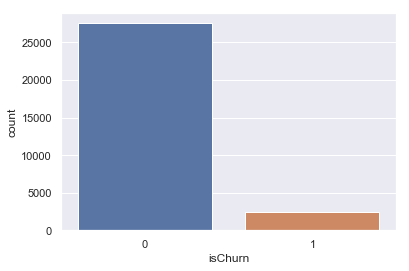

In [184]:
sns.countplot(telecom['isChurn'],label = 'count')
plt.show()

------------------------------------
arpu
------------------------------------


median                 mean                     std            
isChurn         0        1           0           1           0           1
arpu_6   476.0285  556.661  549.220390  663.158246  446.851067  584.538210
arpu_7   482.7645  462.400  562.608191  540.165968  474.005000  540.367084
arpu_8   447.0900   78.357  532.635710  237.200793  503.944081  386.441008

<Figure size 1224x504 with 0 Axes>

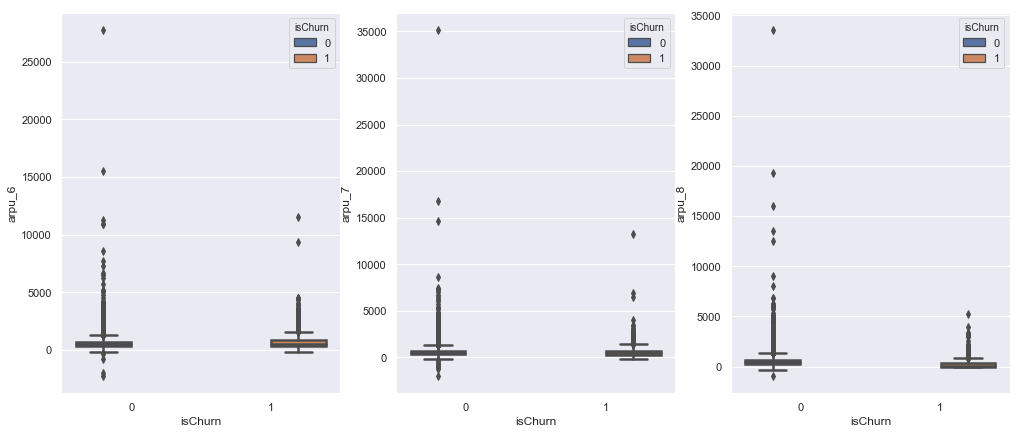

count    30001.000000
mean       558.490824
std        460.640461
min      -2258.709000
25%        309.865000
50%        481.694000
75%        699.943000
max      27731.088000
Name: arpu_6, dtype: float64

{'arpu_6': 1985.115, 'arpu_7': 1999.5, 'arpu_8': 1986.622}


In [185]:
dict_outlier={}
def analyze_feature(telecom_data,feature_start, dict_outlier):
    print('------------------------------------')
    print(feature_start)
    print('------------------------------------')
    
    
    plt.rcParams["figure.figsize"] = [17, 7]
    fig = plt.figure()
    cols = [ feature_start + "_" + str(c) for c in [6,7,8]]
    
    for c in cols:
        p99=telecom_data[c].quantile(.99)
        dict_outlier[c]=p99
    display(telecom_data.pivot_table(values=cols, columns='isChurn', aggfunc=[np.median, np.mean, np.std]))
    f,axes = plt.subplots(nrows=1, ncols=3)
    sns.boxplot(data=telecom_data, y=feature_start + "_6", x="isChurn",
                hue="isChurn", linewidth=2.5, ax=axes[0])
    sns.boxplot(data=telecom_data, y=feature_start + "_7",  x="isChurn",
                hue="isChurn", linewidth=2.5, ax=axes[1])
    sns.boxplot(data=telecom_data, y=feature_start + "_8",  x="isChurn",
                hue="isChurn", linewidth=2.5,  ax=axes[2])

    plt.show()
analyze_feature(telecom,'arpu',dict_outlier)
display(telecom['arpu_6'].describe())
print(dict_outlier)

In [186]:
columns = list(telecom.columns)
columns

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

------------------------------------
std_ic_t2m_mou
------------------------------------


median             mean                    std            
isChurn               0     1          0          1           0           1
std_ic_t2m_mou_6   4.91  6.46  29.015369  31.225756   98.802850   91.250270
std_ic_t2m_mou_7   5.36  3.18  31.216970  26.368972  104.960637  113.236084
std_ic_t2m_mou_8   4.63  0.00  29.566489   9.362306  106.394309   55.477346

<Figure size 1224x504 with 0 Axes>

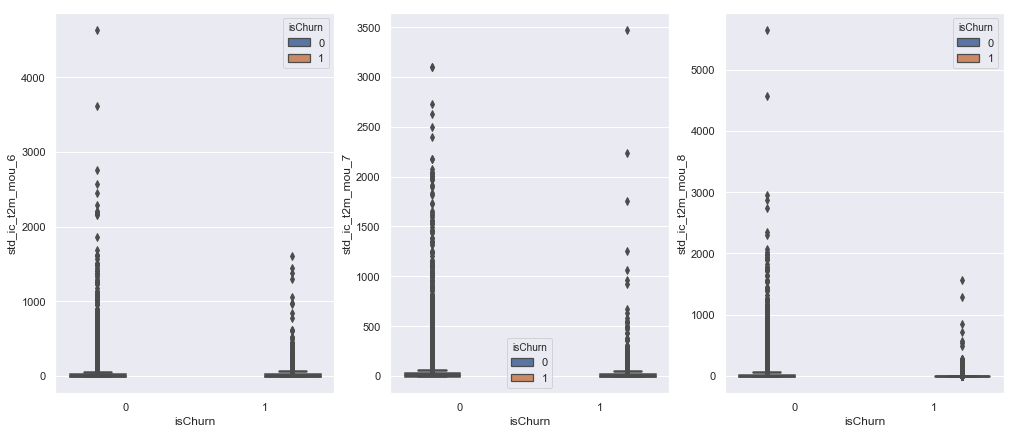

------------------------------------
og_others
------------------------------------


median           mean                 std          
isChurn          0    1         0         1         0         1
og_others_6    0.0  0.0  0.648409  0.804281  4.223969  2.437763
og_others_7    0.0  0.0  0.031929  0.166833  1.676007  7.506902
og_others_8    0.0  0.0  0.049943  0.144138  2.738332  7.100904

<Figure size 1224x504 with 0 Axes>

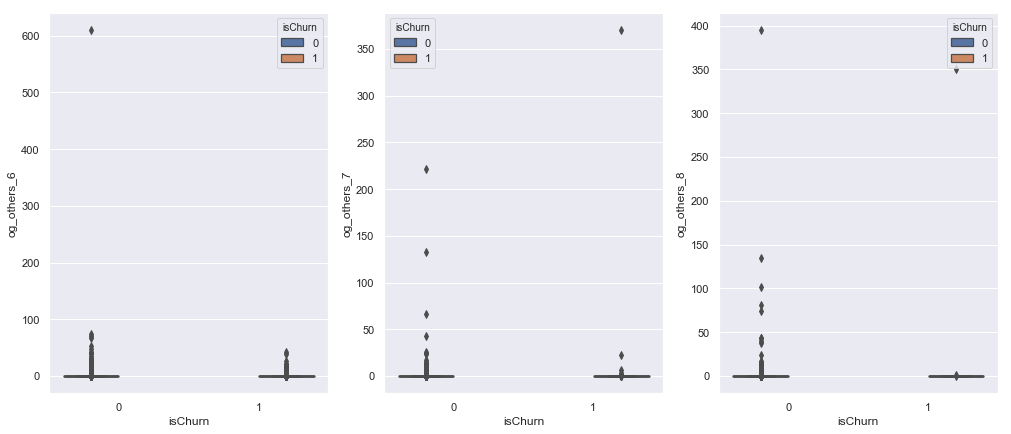

------------------------------------
loc_og_t2m_mou
------------------------------------


median               mean                     std            
isChurn               0      1           0           1           0           1
loc_og_t2m_mou_6  81.28  39.51  167.719927  112.700107  252.404165  216.376464
loc_og_t2m_mou_7  84.70  27.88  169.597689   88.631540  244.255113  194.065358
loc_og_t2m_mou_8  78.62   0.00  162.359519   32.047431  238.804632  107.541302

<Figure size 1224x504 with 0 Axes>

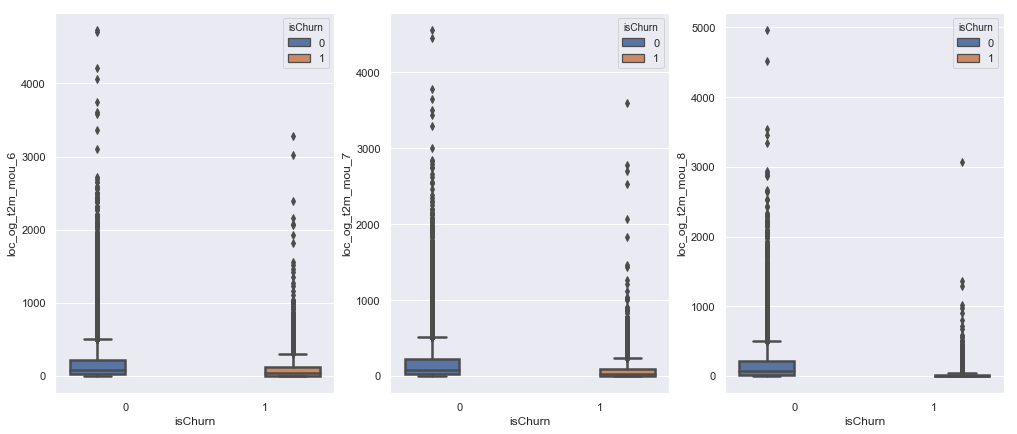

------------------------------------
isd_ic_mou
------------------------------------


median            mean                   std           
isChurn           0    1          0          1          0          1
isd_ic_mou_6    0.0  0.0  10.694935  11.798058  78.443157  53.711547
isd_ic_mou_7    0.0  0.0  12.016992  10.281626  81.945907  56.512703
isd_ic_mou_8    0.0  0.0  11.625108   3.920823  73.087624  29.929621

<Figure size 1224x504 with 0 Axes>

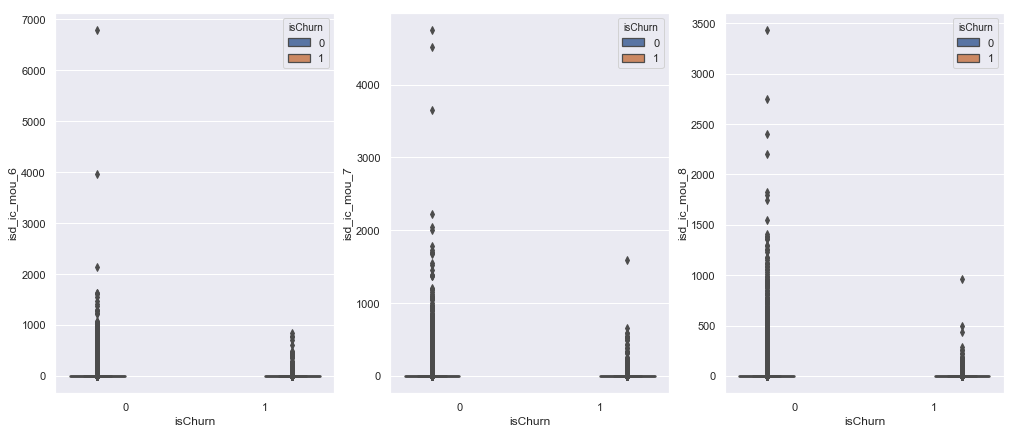

------------------------------------
loc_ic_t2m_mou
------------------------------------


median               mean                     std  \
isChurn                0      1           0           1           0   
loc_ic_t2m_mou_6  87.585  47.86  154.065033  109.172421  220.362854   
loc_ic_t2m_mou_7  91.490  33.83  157.510400   85.178738  220.771323   
loc_ic_t2m_mou_8  89.860   0.00  156.537174   29.890889  219.913939   

                              
isChurn                    1  
loc_ic_t2m_mou_6  201.090539  
loc_ic_t2m_mou_7  174.086254  
loc_ic_t2m_mou_8   82.127684

<Figure size 1224x504 with 0 Axes>

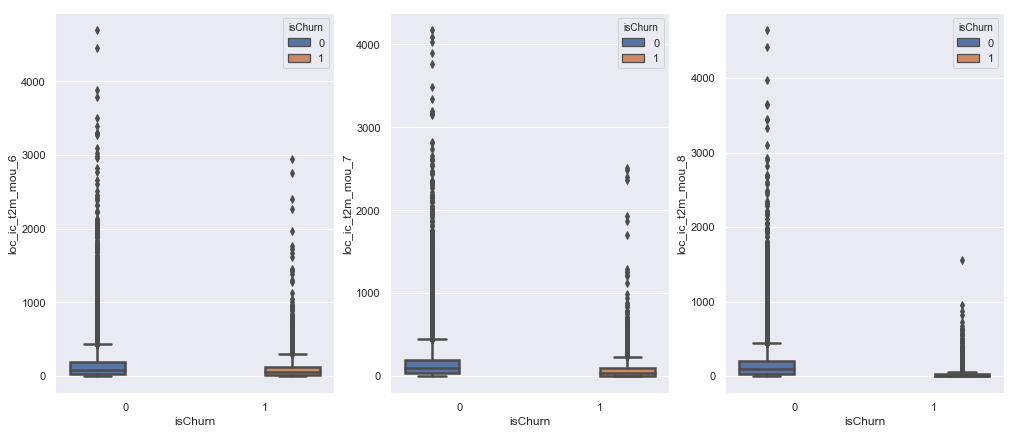

------------------------------------
vol_data_mb
------------------------------------


median             mean                     std            
isChurn             0    1           0           1           0           1
vol_data_mb_6  49.695  0.0  477.655971  393.156420  977.417757  845.266555
vol_data_mb_7  99.925  0.0  511.777594  309.187050  977.826064  808.732363
vol_data_mb_8   7.880  0.0  488.128121  110.552429  991.081499  538.251776

<Figure size 1224x504 with 0 Axes>

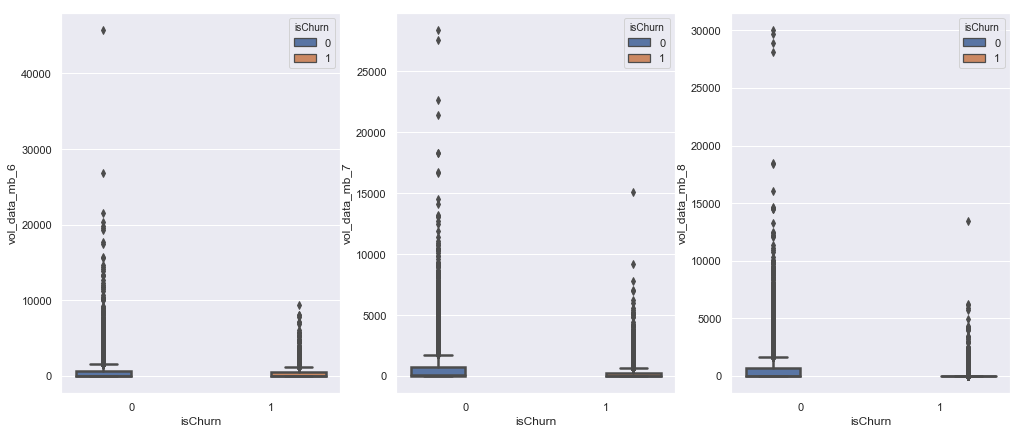

------------------------------------
arpu_data
------------------------------------


median               mean                     std            
isChurn           0      1           0           1           0           1
arpu_data_6  49.600  70.01  152.054233  166.560541  327.462420  322.588542
arpu_data_7  46.525  51.61  155.768230  129.708902  339.587647  286.717378
arpu_data_8  41.965  11.72  147.106769   45.268644  319.315621  180.475239

<Figure size 1224x504 with 0 Axes>

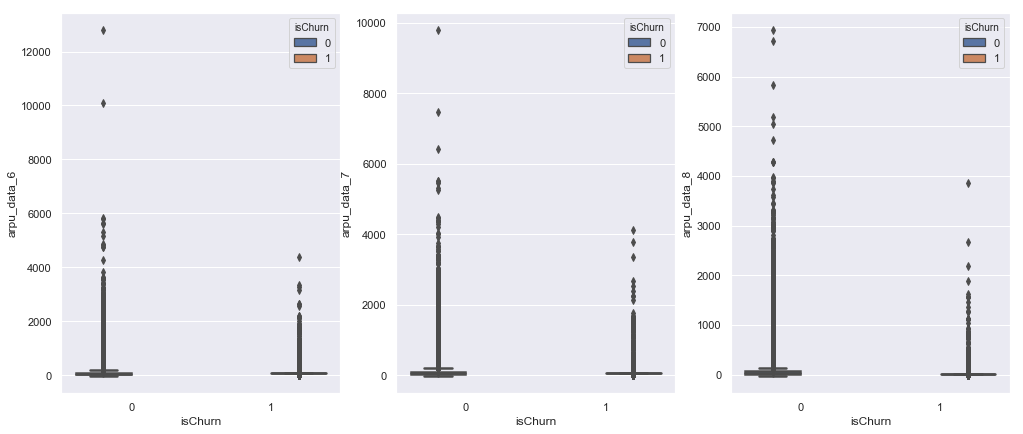

------------------------------------
last_rech_data
------------------------------------


median         mean                 std          
isChurn               0  1         0         1         0         1
last_rech_data_6      1 -1  0.133745 -0.071692  0.991034  0.997631
last_rech_data_7      1 -1  0.168505 -0.217534  0.985719  0.976253
last_rech_data_8      1 -1  0.124383 -0.623925  0.992252  0.781645

<Figure size 1224x504 with 0 Axes>

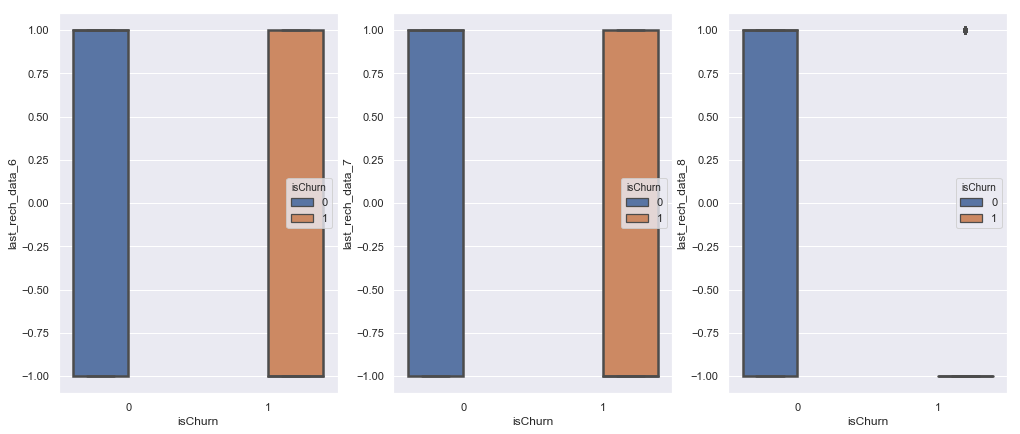

------------------------------------
loc_ic_t2f_mou
------------------------------------


median            mean                  std           
isChurn               0    1          0         1          0          1
loc_ic_t2f_mou_6   2.11  0.0  15.901868  8.239988  46.766561  31.303354
loc_ic_t2f_mou_7   2.38  0.0  16.817191  7.210660  50.372133  31.264112
loc_ic_t2f_mou_8   2.23  0.0  15.453274  2.547075  44.833695  14.191615

<Figure size 1224x504 with 0 Axes>

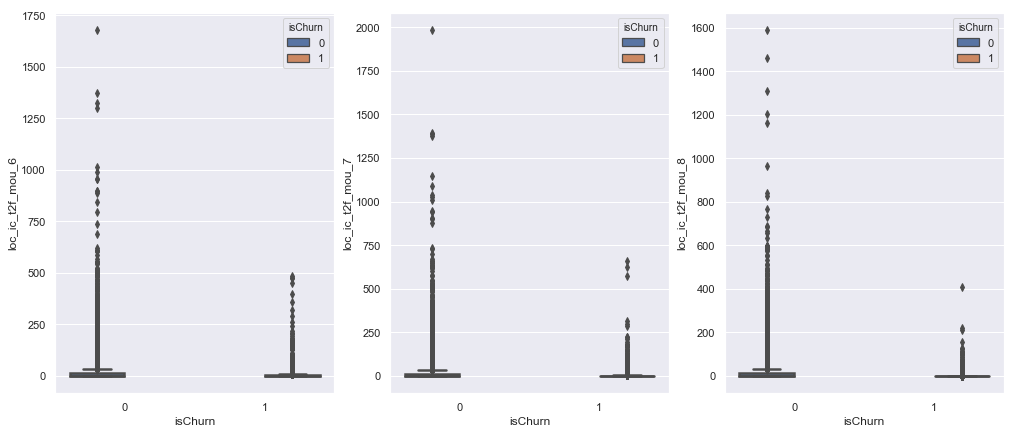

------------------------------------
onnet_mou
------------------------------------


median                mean                     std            
isChurn           0       1           0           1           0           1
onnet_mou_6  83.295  113.01  251.203938  369.058173  442.806716  608.456336
onnet_mou_7  83.780   71.43  265.641432  292.408353  474.160377  541.015921
onnet_mou_8  73.580    2.36  244.819433  113.226846  465.991963  339.977782

<Figure size 1224x504 with 0 Axes>

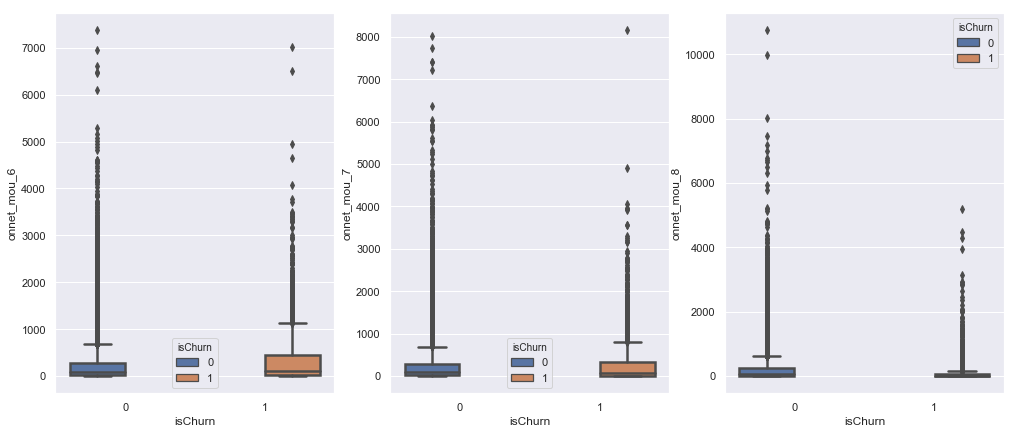

------------------------------------
roam_og_mou
------------------------------------


median            mean                    std            
isChurn            0    1          0          1           0           1
roam_og_mou_6    0.0  0.0  24.337114  51.799316  105.613537  198.376036
roam_og_mou_7    0.0  0.0  17.496533  50.134482   86.341029  168.435416
roam_og_mou_8    0.0  0.0  17.760013  43.638824   95.312760  177.782354

<Figure size 1224x504 with 0 Axes>

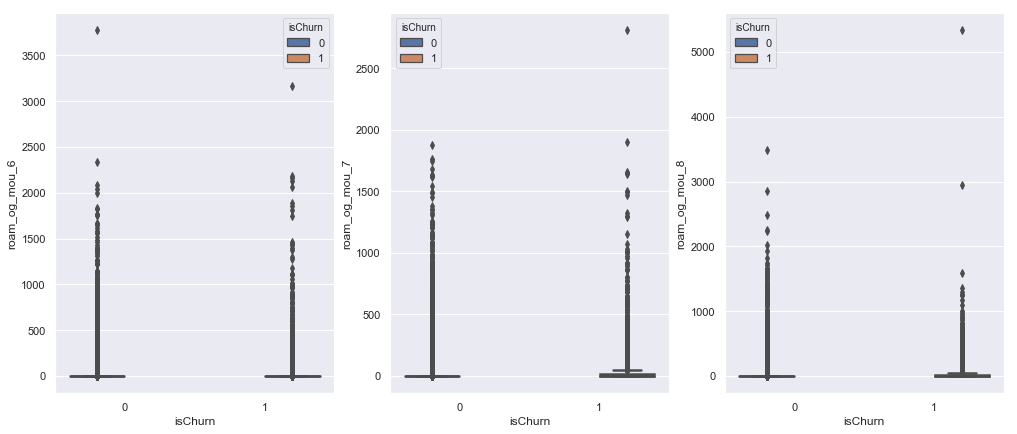

------------------------------------
isd_og_mou
------------------------------------


median           mean                  std           
isChurn           0    1         0         1          0          1
isd_og_mou_6    0.0  0.0  1.979834  4.335809  46.093310  42.985844
isd_og_mou_7    0.0  0.0  2.015143  3.128664  46.303480  35.881271
isd_og_mou_8    0.0  0.0  2.011903  1.238419  46.338862  18.066851

<Figure size 1224x504 with 0 Axes>

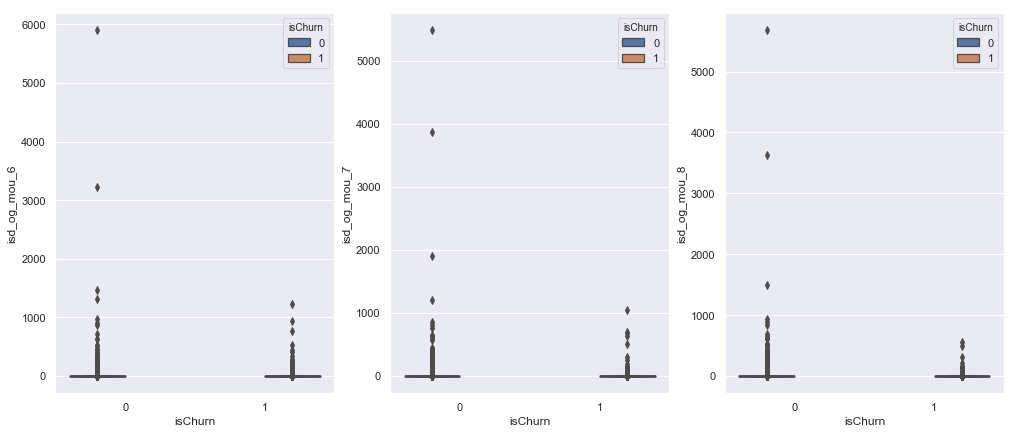

------------------------------------
roam_ic_mou
------------------------------------


median            mean                   std            
isChurn            0    1          0          1          0           1
roam_ic_mou_6    0.0  0.0  14.972025  28.962614  68.745039  134.257387
roam_ic_mou_7    0.0  0.0  11.108306  29.964297  66.489819  142.679770
roam_ic_mou_8    0.0  0.0  11.195356  27.236800  66.216384  133.404714

<Figure size 1224x504 with 0 Axes>

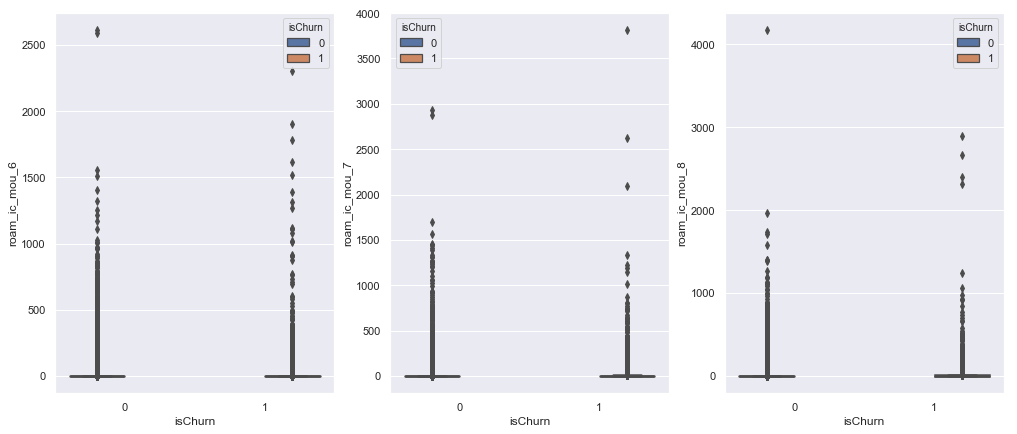

------------------------------------
loc_og_t2t_mou
------------------------------------


median              mean                    std            
isChurn               0      1          0          1           0           1
loc_og_t2t_mou_6  25.63  12.38  86.676673  59.736981  231.722008  190.975196
loc_og_t2t_mou_7  26.61   8.28  89.304021  44.692946  246.755866  147.513552
loc_og_t2t_mou_8  24.59   0.00  83.569354  16.067210  235.486686   71.543220

<Figure size 1224x504 with 0 Axes>

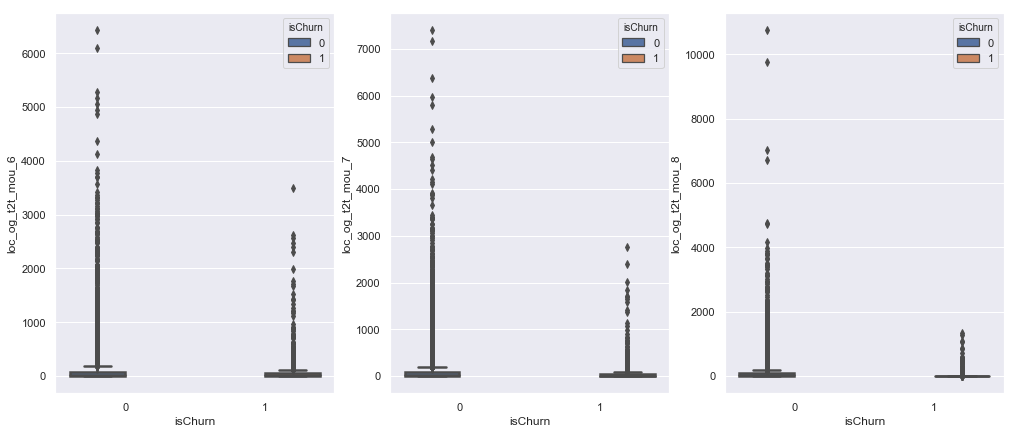

------------------------------------
loc_og_mou
------------------------------------


median               mean                     std            
isChurn             0      1           0           1           0           1
loc_og_mou_6  131.320  64.48  260.990931  176.057218  382.438671  318.343730
loc_og_mou_7  138.040  45.16  265.637857  136.323040  381.595990  269.841147
loc_og_mou_8  128.385   0.00  252.229627   49.419271  372.212809  144.308743

<Figure size 1224x504 with 0 Axes>

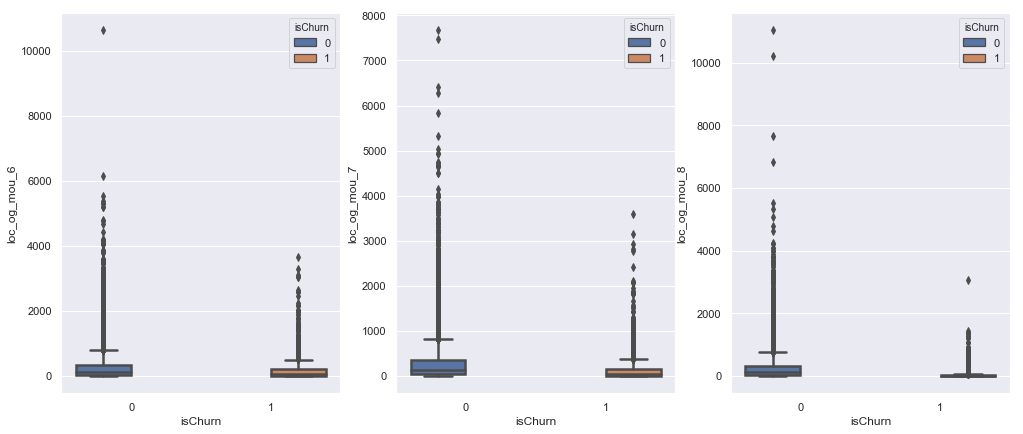

------------------------------------
std_og_t2f_mou
------------------------------------


median           mean                  std          
isChurn               0    1         0         1          0         1
std_og_t2f_mou_6    0.0  0.0  1.855096  1.221549  12.162364  9.659972
std_og_t2f_mou_7    0.0  0.0  1.891816  1.083531  13.250161  9.380655
std_og_t2f_mou_8    0.0  0.0  1.695854  0.330131  11.323689  4.396777

<Figure size 1224x504 with 0 Axes>

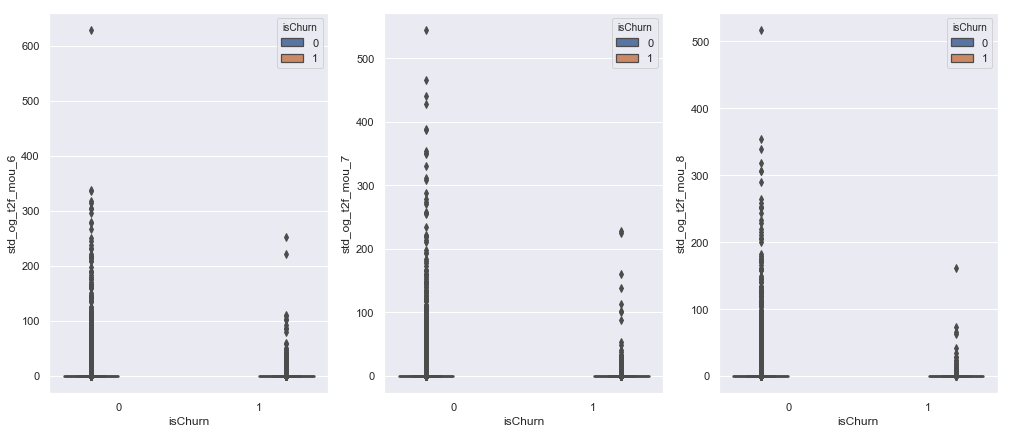

------------------------------------
offnet_mou
------------------------------------


median                mean                     std            
isChurn             0       1           0           1           0           1
offnet_mou_6  221.440  239.14  365.046203  471.331073  463.186869  655.047666
offnet_mou_7  224.825  162.19  377.809741  381.416104  489.359610  596.465196
offnet_mou_8  202.790   10.28  352.510204  138.248751  490.182443  317.998389

<Figure size 1224x504 with 0 Axes>

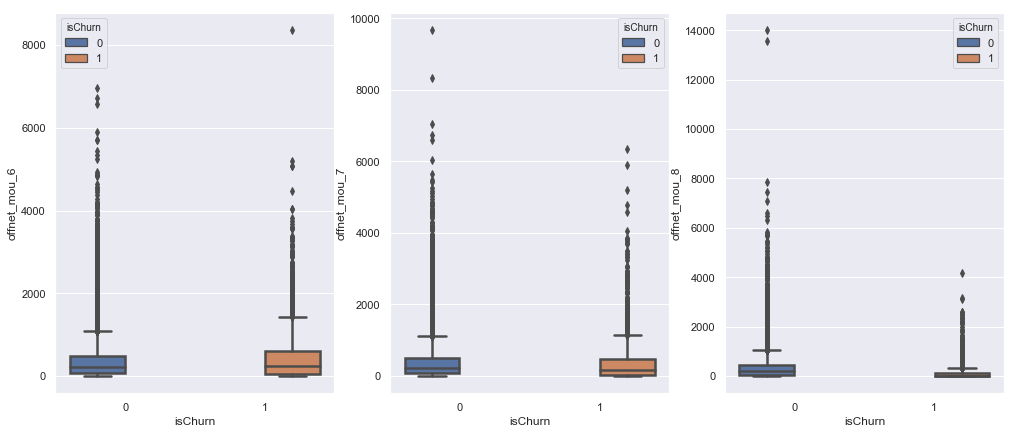

------------------------------------
last_rech
------------------------------------


median         mean                 std          
isChurn          0  1         0         1         0         1
last_rech_6      1  1  0.995936  0.986071  0.090064  0.166357
last_rech_7      1  1  0.996734  0.956575  0.080751  0.291545
last_rech_8      1  1  0.981422  0.732077  0.191863  0.681361

<Figure size 1224x504 with 0 Axes>

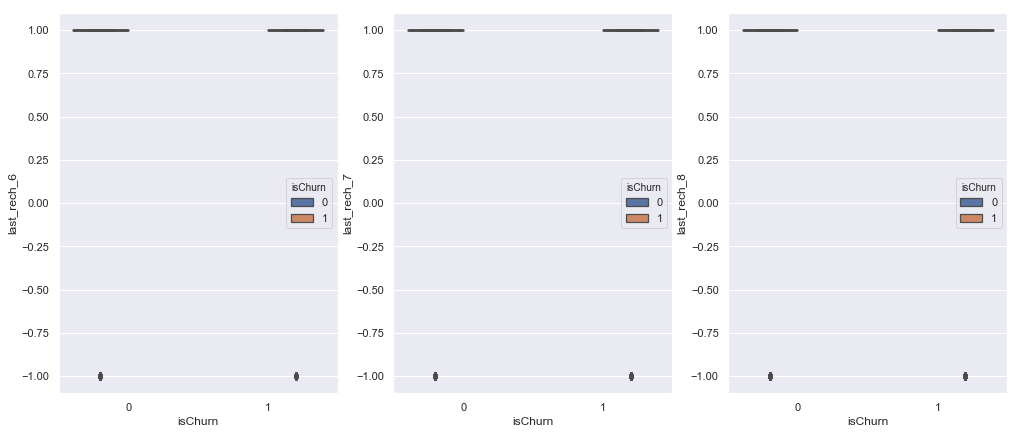

------------------------------------
std_ic_mou
------------------------------------


median              mean                    std            
isChurn            0      1          0          1           0           1
std_ic_mou_6  11.235  14.16  46.145362  54.061290  136.473204  148.454487
std_ic_mou_7  12.410   8.26  49.516550  43.734678  147.871160  151.325754
std_ic_mou_8  10.930   0.00  47.055210  14.441794  143.186790   66.102622

<Figure size 1224x504 with 0 Axes>

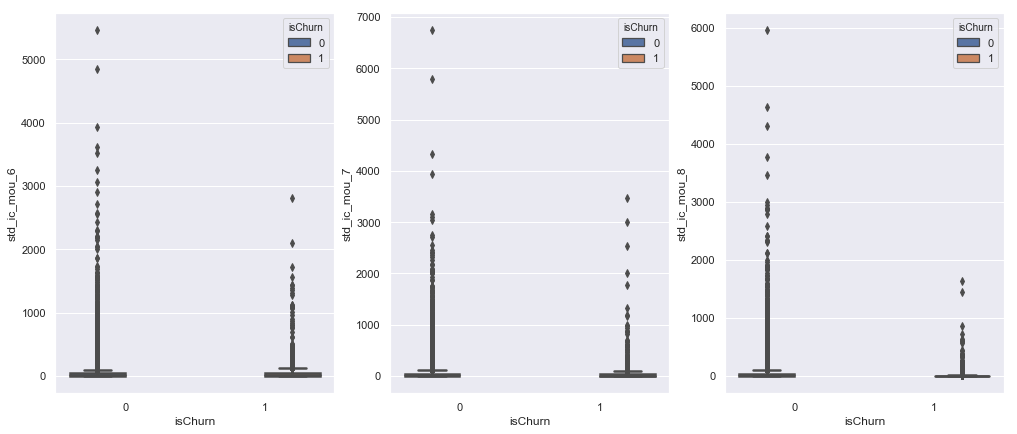

------------------------------------
std_og_t2m_mou
------------------------------------


median               mean                     std  \
isChurn                0      1           0           1           0   
std_og_t2m_mou_6  15.010  49.89  167.559669  313.493085  384.541979   
std_og_t2m_mou_7  15.735  21.83  182.243052  252.024764  421.657489   
std_og_t2m_mou_8  12.290   0.00  164.541592   76.154490  419.063565   

                              
isChurn                    1  
std_og_t2m_mou_6  606.011260  
std_og_t2m_mou_7  547.098275  
std_og_t2m_mou_8  258.953900

<Figure size 1224x504 with 0 Axes>

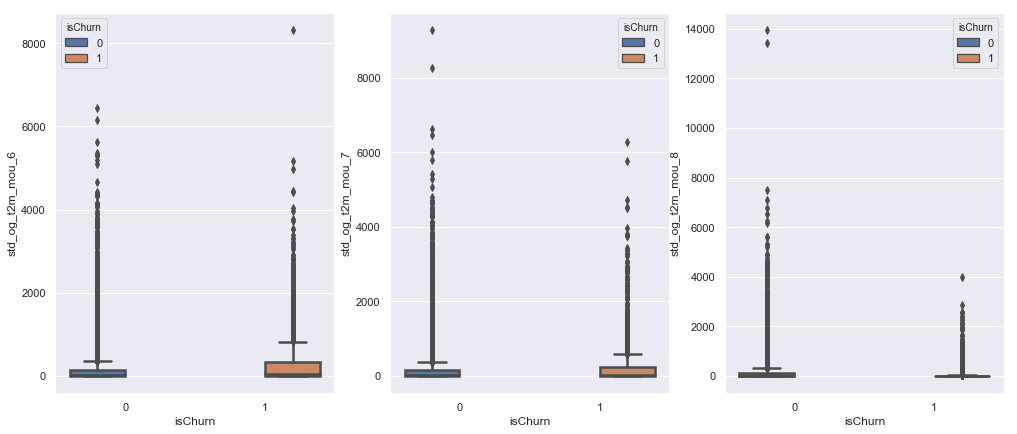

------------------------------------
sachet_3g
------------------------------------


median         mean                 std          
isChurn          0  1         0         1         0         1
sachet_3g_6      0  0  0.206313  0.244162  0.974304  1.105589
sachet_3g_7      0  0  0.228048  0.221221  1.073072  1.264999
sachet_3g_8      0  0  0.214550  0.065137  1.133755  0.584164

<Figure size 1224x504 with 0 Axes>

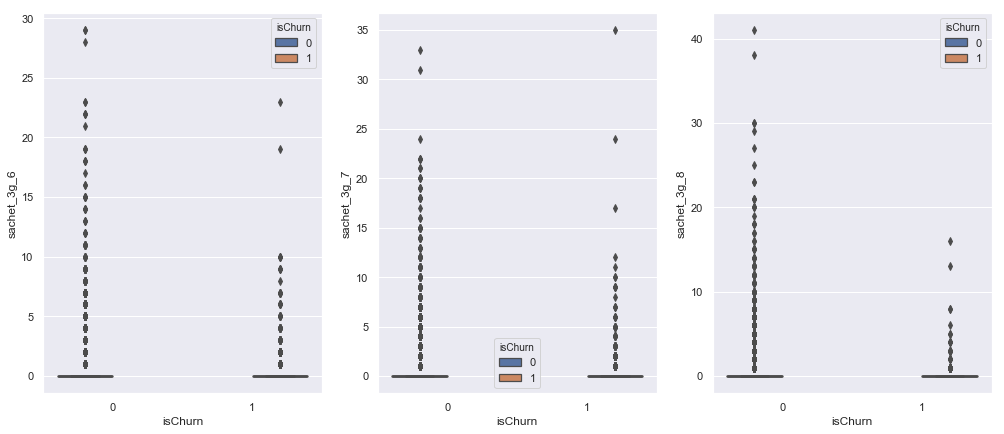

------------------------------------
fb_user
------------------------------------


median           mean                 std          
isChurn        0    1         0         1         0         1
fb_user_6    1.0  0.0  0.525653  0.425236  0.499351  0.494480
fb_user_7    1.0  0.0  0.539006  0.355182  0.498485  0.478667
fb_user_8    1.0  0.0  0.506713  0.142565  0.499964  0.349700

<Figure size 1224x504 with 0 Axes>

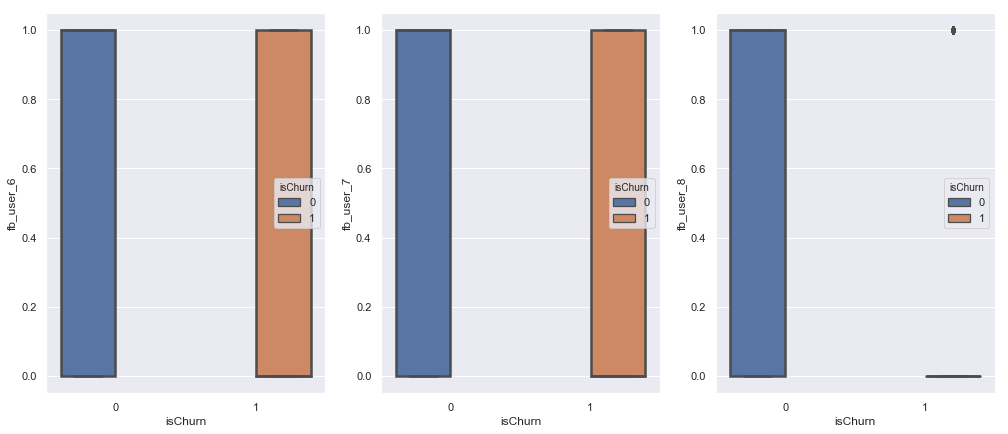

------------------------------------
total_rech_data_amt
------------------------------------


median             mean                      std  \
isChurn                    0    1           0           1            0   
total_rech_data_amt_6   98.0  0.0  460.077071  407.229283  1446.356360   
total_rech_data_amt_7  149.0  0.0  545.056789  338.293761  1498.871490   
total_rech_data_amt_8   91.0  0.0  496.885741   83.523376  1683.029136   

                                   
isChurn                         1  
total_rech_data_amt_6  1055.93679  
total_rech_data_amt_7  1171.75966  
total_rech_data_amt_8   476.78360

<Figure size 1224x504 with 0 Axes>

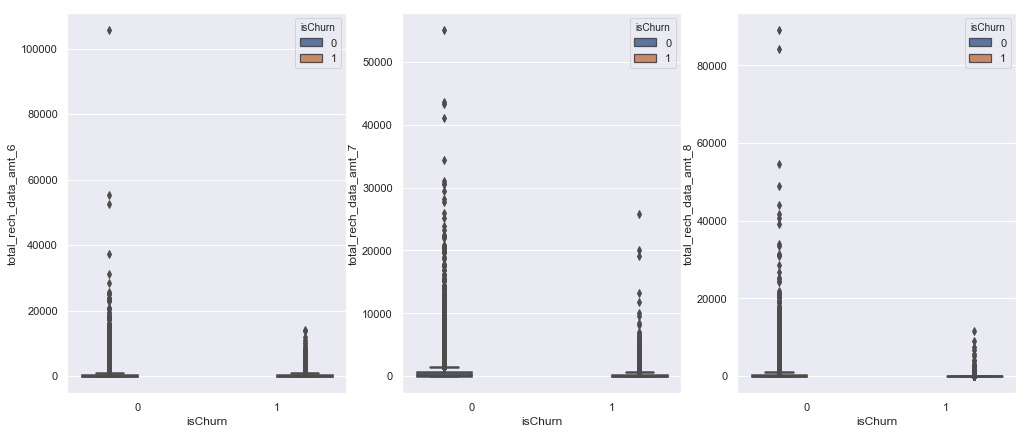

------------------------------------
spl_og_mou
------------------------------------


median            mean                  std           
isChurn           0     1         0         1          0          1
spl_og_mou_6   0.21  0.36  5.697971  7.176501  17.129648  21.868056
spl_og_mou_7   0.75  0.10  7.088959  7.330922  21.730005  22.439391
spl_og_mou_8   0.70  0.00  6.898655  2.702061  20.898863  11.105250

<Figure size 1224x504 with 0 Axes>

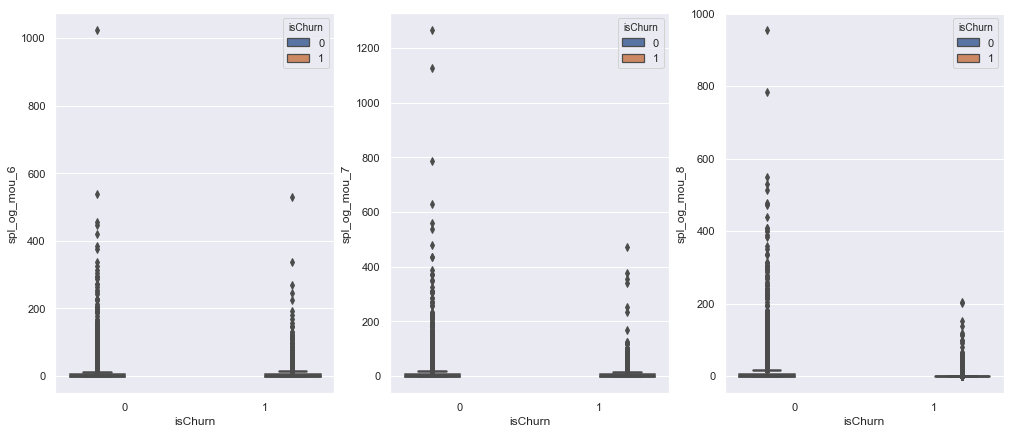

------------------------------------
total_og_mou
------------------------------------


median                mean                     std  \
isChurn               0       1           0           1           0   
total_og_mou_6  403.785  531.16  593.763075  791.678435  666.580153   
total_og_mou_7  431.415  334.63  628.442026  627.508218  706.777660   
total_og_mou_8  367.735    0.00  581.998003  209.361368  708.981932   

                            
isChurn                  1  
total_og_mou_6  902.201696  
total_og_mou_7  826.165968  
total_og_mou_8  477.371897

<Figure size 1224x504 with 0 Axes>

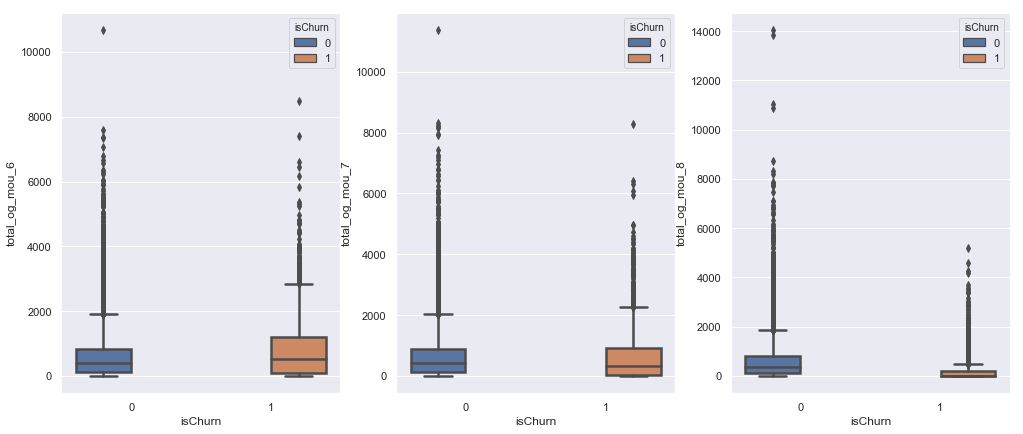

------------------------------------
total_rech_amt
------------------------------------


median             mean                     std            
isChurn               0    1           0           1           0           1
total_rech_amt_6    558  660  649.574710  786.707087  547.703439  681.561804
total_rech_amt_7    565  526  663.527830  626.290045  574.159545  667.938132
total_rech_amt_8    510   45  613.701089  253.152806  614.833238  452.360091

<Figure size 1224x504 with 0 Axes>

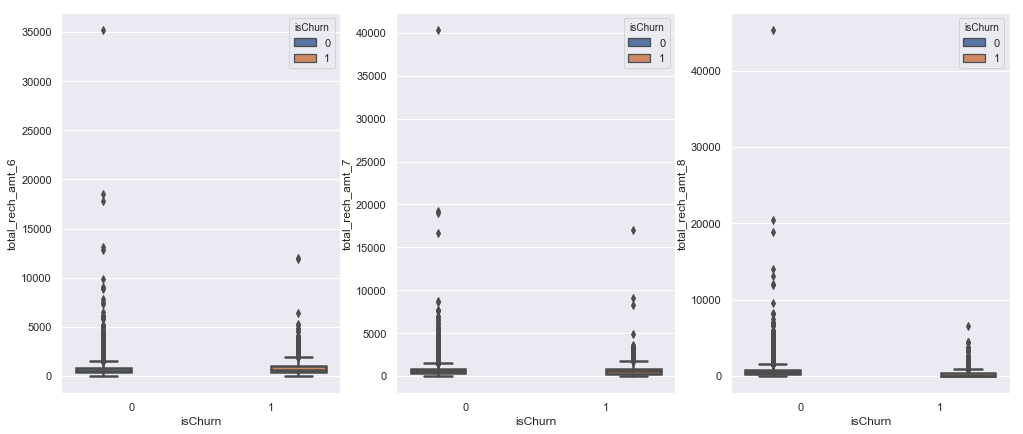

------------------------------------
std_og_mou
------------------------------------


median                mean                     std            
isChurn            0       1           0           1           0           1
std_og_mou_6  39.695  227.18  324.436966  603.294965  577.000448  850.097081
std_og_mou_7  42.080   96.04  353.660138  480.551340  626.212911  767.455865
std_og_mou_8  32.180    0.00  320.799988  155.853810  620.988840  423.231067

<Figure size 1224x504 with 0 Axes>

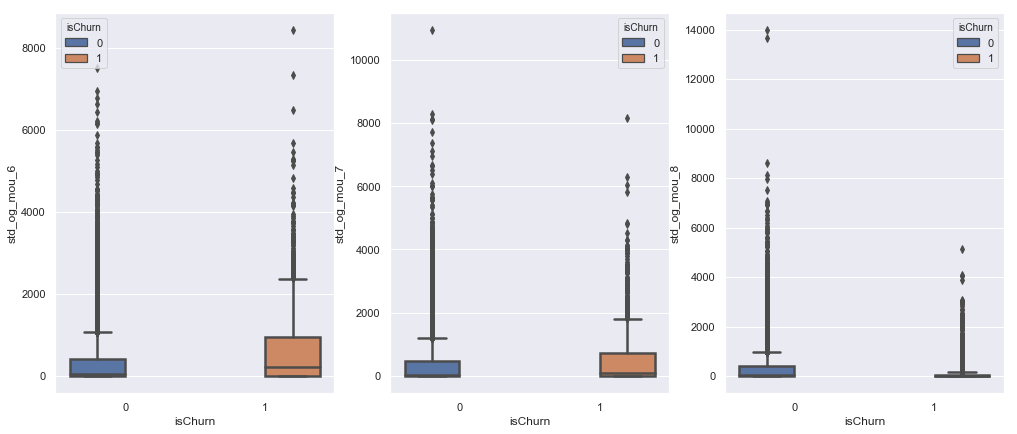

------------------------------------
std_og_t2t_mou
------------------------------------


median               mean                     std            
isChurn               0      1           0           1           0           1
std_og_t2t_mou_6   2.10  19.18  155.018506  288.576297  383.400240  573.082309
std_og_t2t_mou_7   2.38   6.61  169.521561  227.439226  412.028164  510.503798
std_og_t2t_mou_8   1.36   0.00  154.559050   79.367583  404.445937  300.984676

<Figure size 1224x504 with 0 Axes>

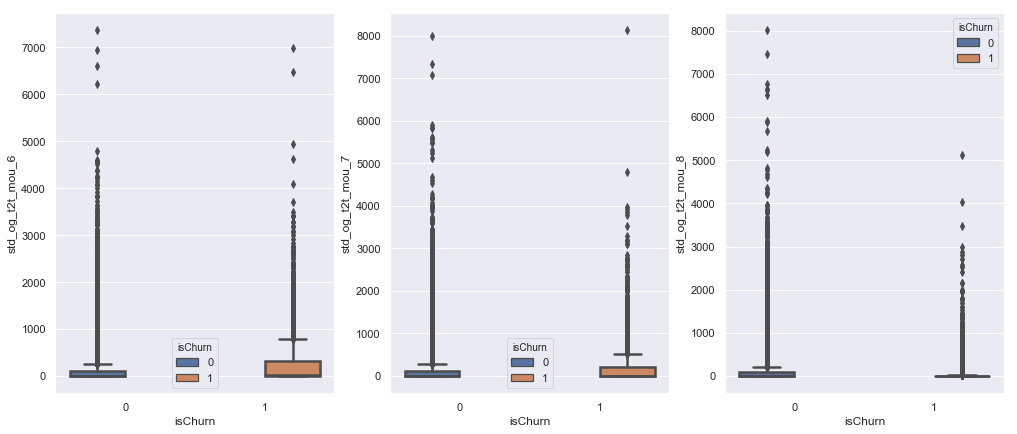

------------------------------------
loc_og_t2f_mou
------------------------------------


median           mean                  std           
isChurn               0    1         0         1          0          1
loc_og_t2f_mou_6   0.20  0.0  6.585973  3.613421  21.071281  31.542191
loc_og_t2f_mou_7   0.30  0.0  6.727577  2.992581  21.488743  26.312446
loc_og_t2f_mou_8   0.18  0.0  6.292444  1.301794  20.170173   7.637488

<Figure size 1224x504 with 0 Axes>

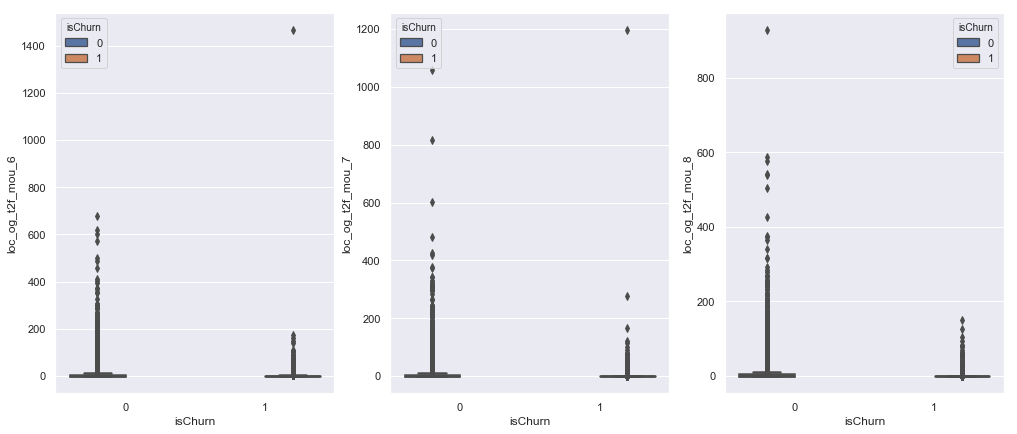

------------------------------------
sachet_2g
------------------------------------


median         mean                 std          
isChurn          0  1         0         1         0         1
sachet_2g_6      0  0  1.069303  1.029496  2.507173  2.507683
sachet_2g_7      0  0  1.243832  0.877509  2.765831  2.349954
sachet_2g_8      0  0  1.124383  0.269971  2.614660  1.087765

<Figure size 1224x504 with 0 Axes>

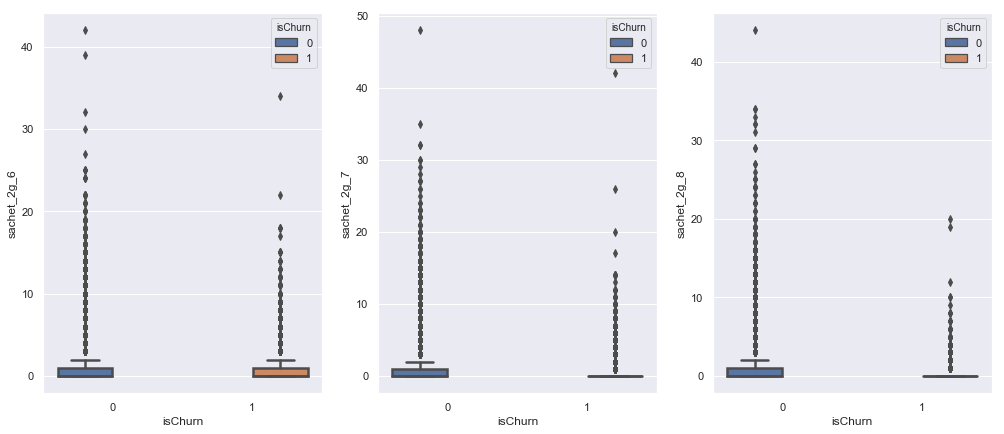

------------------------------------
monthly_3g
------------------------------------


median         mean                 std          
isChurn           0  1         0         1         0         1
monthly_3g_6      0  0  0.219557  0.197460  0.617207  0.565694
monthly_3g_7      0  0  0.236575  0.143794  0.673411  0.460100
monthly_3g_8      0  0  0.224673  0.056944  0.636551  0.294126

<Figure size 1224x504 with 0 Axes>

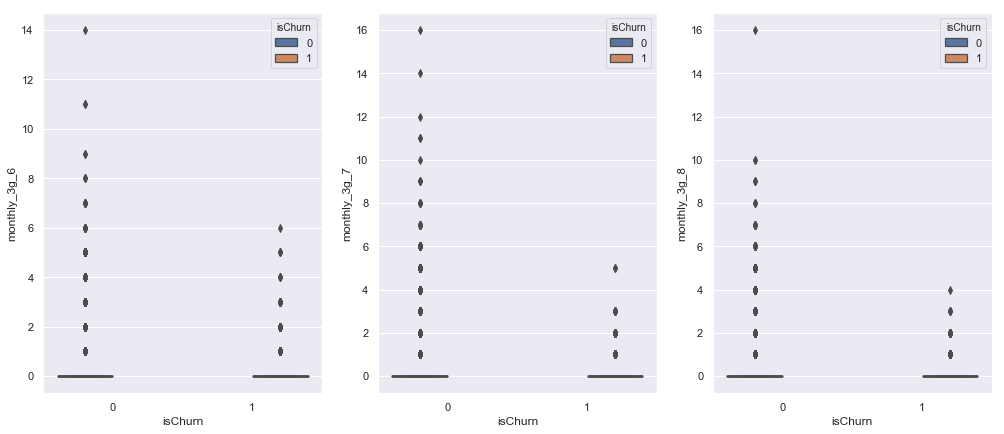

------------------------------------
arpu
------------------------------------


median                 mean                     std            
isChurn         0        1           0           1           0           1
arpu_6   476.0285  556.661  549.220390  663.158246  446.851067  584.538210
arpu_7   482.7645  462.400  562.608191  540.165968  474.005000  540.367084
arpu_8   447.0900   78.357  532.635710  237.200793  503.944081  386.441008

<Figure size 1224x504 with 0 Axes>

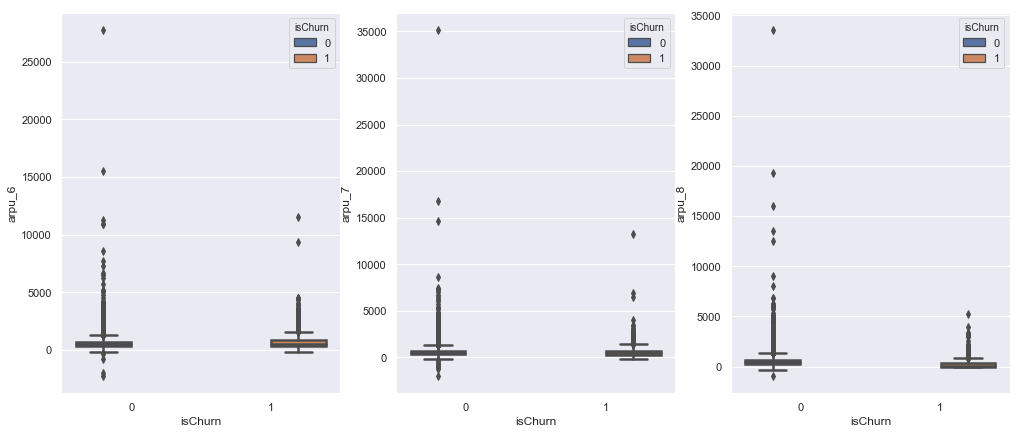

------------------------------------
count_rech_data
------------------------------------


median           mean                 std          
isChurn                0    1         0         1         0         1
count_rech_data_6    1.0  0.0  1.676851  1.564523  2.822661  2.924885
count_rech_data_7    1.0  0.0  1.901669  1.313396  3.106814  2.863081
count_rech_data_8    1.0  0.0  1.728810  0.414994  3.074856  1.409658

<Figure size 1224x504 with 0 Axes>

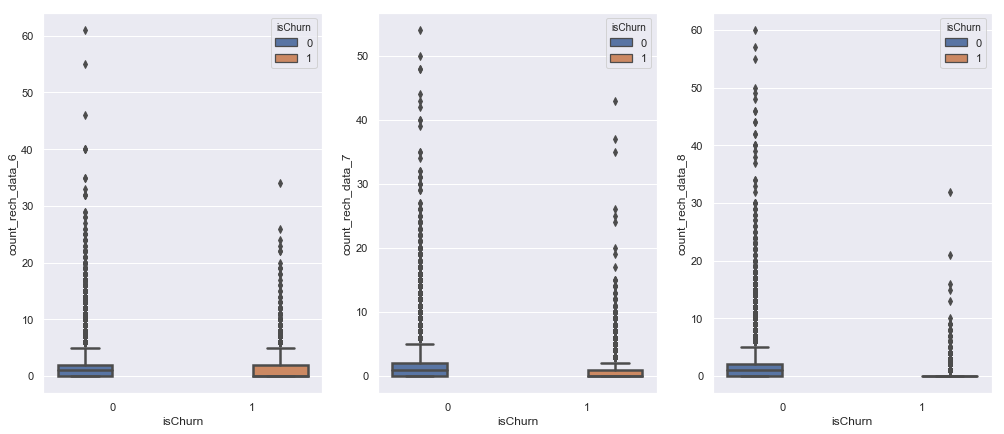

------------------------------------
loc_og_t2c_mou
------------------------------------


median           mean                 std           
isChurn               0    1         0         1         0          1
loc_og_t2c_mou_6    0.0  0.0  1.575349  1.572343  6.262552   6.748645
loc_og_t2c_mou_7    0.0  0.0  1.880327  1.997677  8.916835  11.547548
loc_og_t2c_mou_8    0.0  0.0  1.779188  0.901135  7.355753   5.195016

<Figure size 1224x504 with 0 Axes>

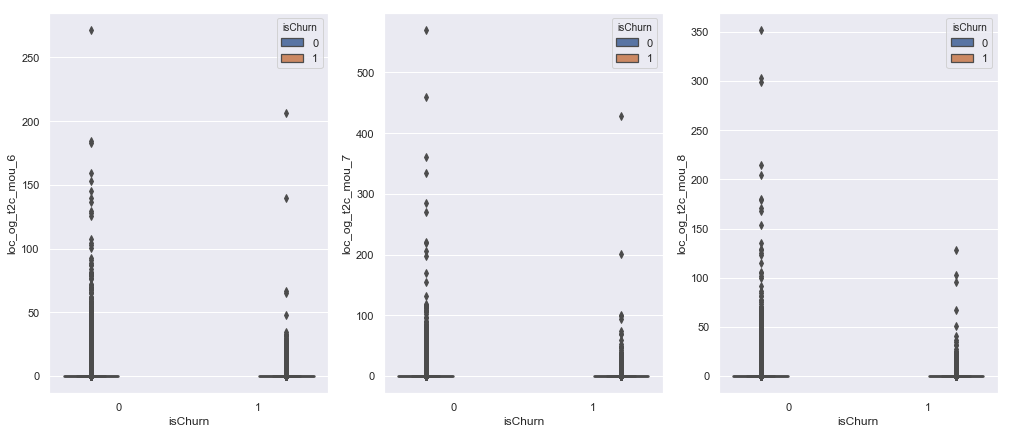

------------------------------------
max_rech_data
------------------------------------


median            mean                    std            
isChurn              0    1          0          1           0           1
max_rech_data_6   25.0  0.0  79.204463  65.378943  111.481438  125.313683
max_rech_data_7   25.0  0.0  82.188498  53.346579  113.313049  121.521335
max_rech_data_8   23.0  0.0  76.952358  22.143794  111.539492   83.852120

<Figure size 1224x504 with 0 Axes>

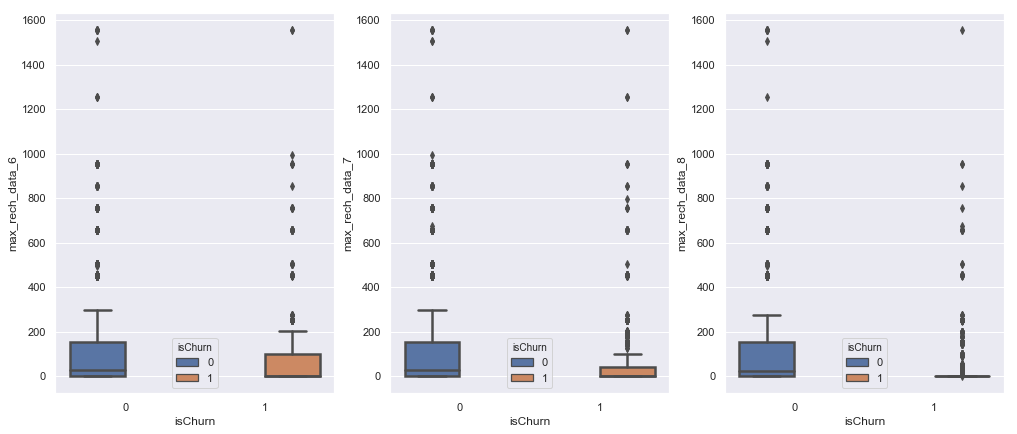

------------------------------------
total_ic_mou
------------------------------------


median                mean                     std            
isChurn              0       1           0           1           0           1
total_ic_mou_6  188.75  128.36  295.131789  231.451344  366.931232  343.932027
total_ic_mou_7  196.73   88.54  306.840677  182.907534  377.810812  301.885135
total_ic_mou_8  191.93    0.00  299.096525   63.444342  368.217149  146.468038

<Figure size 1224x504 with 0 Axes>

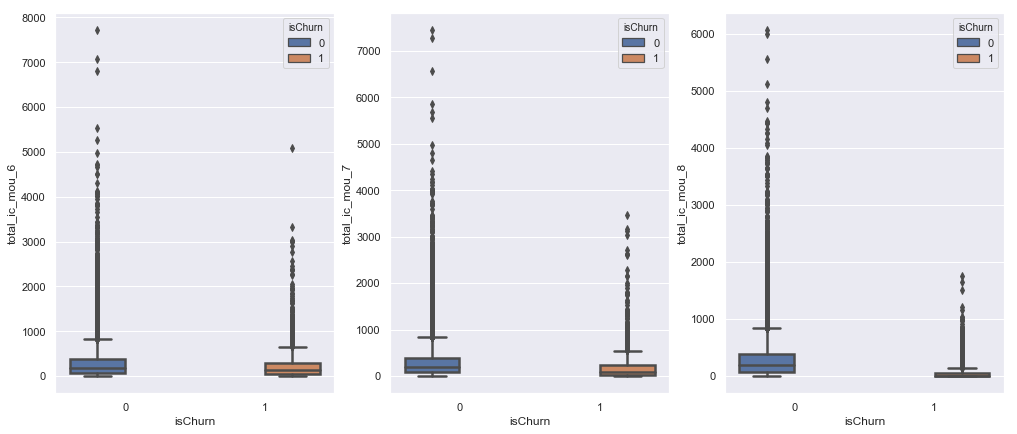

------------------------------------
max_rech_amt
------------------------------------


median             mean                     std            
isChurn             0    1           0           1           0           1
max_rech_amt_6    120  110  169.049456  171.942237  172.004870  209.116174
max_rech_amt_7    130  110  173.336575  159.388775  176.748936  226.966368
max_rech_amt_8    144   30  166.767199   85.370750  171.337039  176.648043

<Figure size 1224x504 with 0 Axes>

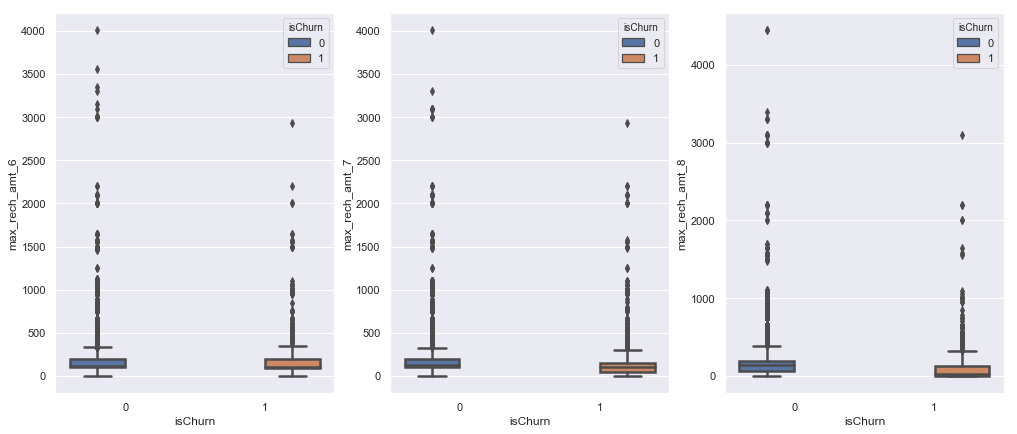

------------------------------------
monthly_2g
------------------------------------


median         mean                 std          
isChurn           0  1         0         1         0         1
monthly_2g_6      0  0  0.181676  0.093404  0.441479  0.342785
monthly_2g_7      0  0  0.193215  0.070873  0.461128  0.281054
monthly_2g_8      0  0  0.165203  0.022941  0.419543  0.157744

<Figure size 1224x504 with 0 Axes>

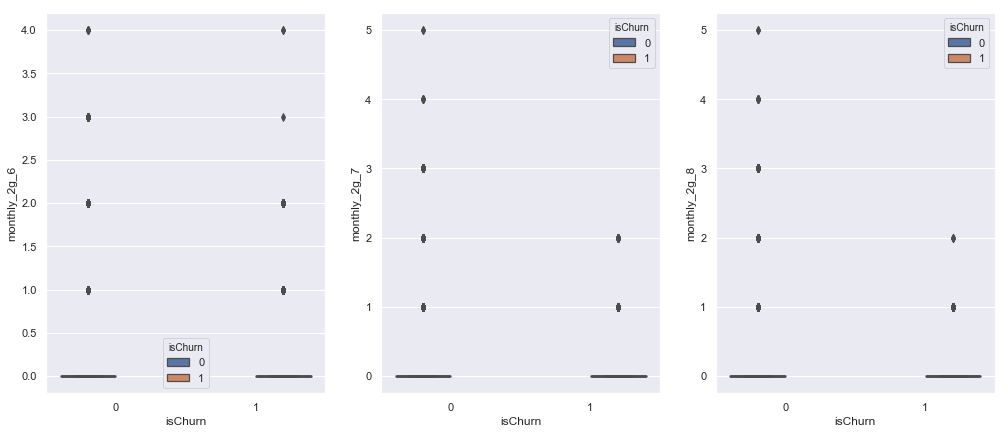

------------------------------------
vbc_3g
------------------------------------


median             mean                     std            
isChurn       0    1           0           1           0           1
vbc_3g_6    0.0  0.0  162.370343  115.096575  421.204044  359.705224
vbc_3g_7    0.0  0.0  186.206078   96.076317  452.598914  312.565748
vbc_3g_8    0.0  0.0  180.501280   40.851975  432.852277  211.713213

<Figure size 1224x504 with 0 Axes>

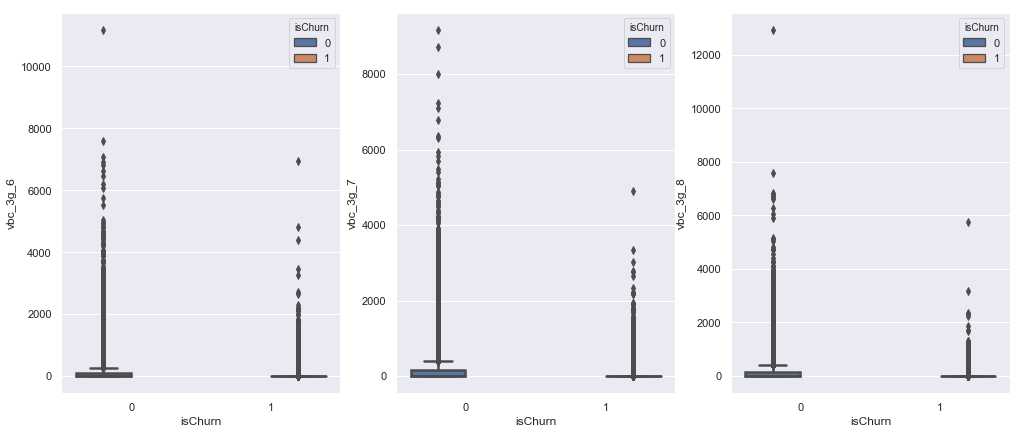

------------------------------------
std_ic_t2t_mou
------------------------------------


median             mean                   std            
isChurn               0     1          0          1          0           1
std_ic_t2t_mou_6   0.33  1.06  14.340590  21.151819  74.993426  103.231267
std_ic_t2t_mou_7   0.45  0.36  15.387952  15.800311  82.664713   87.213910
std_ic_t2t_mou_8   0.31  0.00  14.738447   4.601991  74.027166   24.134480

<Figure size 1224x504 with 0 Axes>

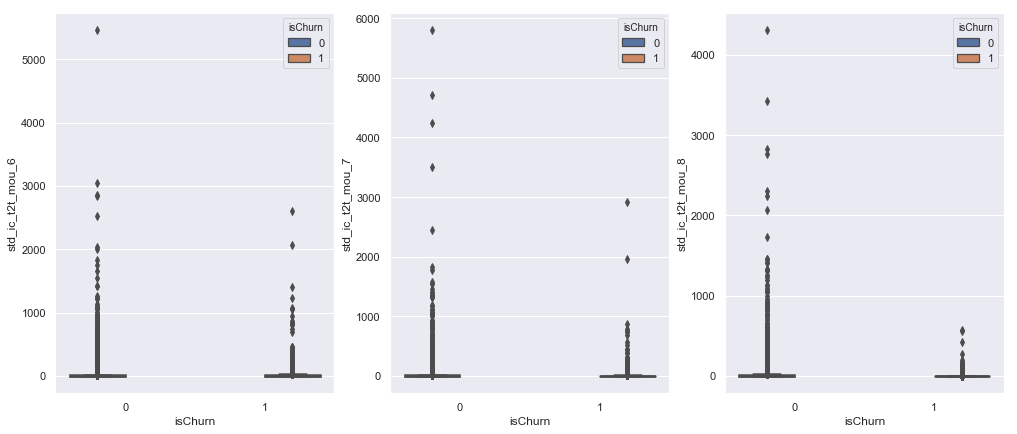

------------------------------------
total_rech_num
------------------------------------


median           mean                  std           
isChurn               0   1          0          1         0          1
total_rech_num_6      9  11  11.669739  13.897583  9.191746  11.589219
total_rech_num_7      9   9  11.747496  11.395330  9.331675  10.499717
total_rech_num_8      8   3  10.392126   5.239246  9.311396   7.339939

<Figure size 1224x504 with 0 Axes>

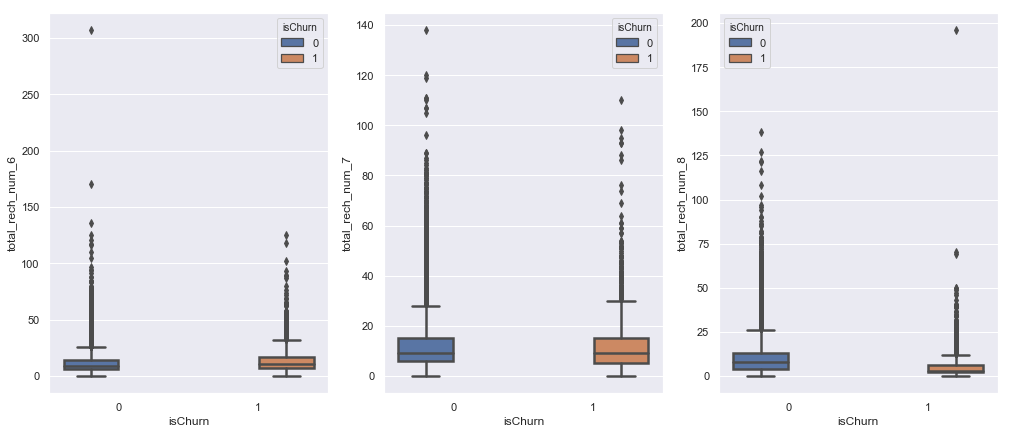

------------------------------------
night_pck_user
------------------------------------


median           mean                 std          
isChurn               0    1         0         1         0         1
night_pck_user_6    0.0  0.0  0.013389  0.015567  0.114936  0.123820
night_pck_user_7    0.0  0.0  0.012772  0.009422  0.112292  0.096630
night_pck_user_8    0.0  0.0  0.012046  0.003687  0.109095  0.060621

<Figure size 1224x504 with 0 Axes>

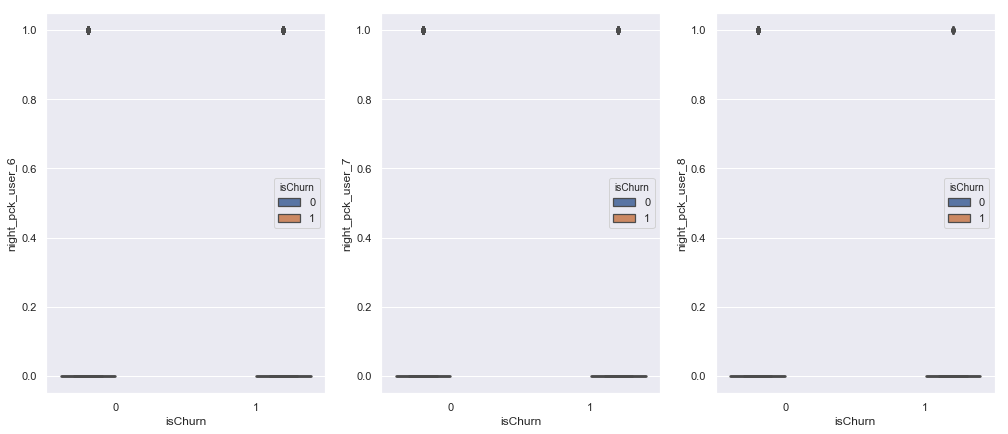

------------------------------------
ic_others
------------------------------------


median           mean                  std          
isChurn          0    1         0         1          0         1
ic_others_6    0.0  0.0  1.175102  0.908976  14.452044  6.775556
ic_others_7    0.0  0.0  1.559204  0.835711  16.591782  6.059804
ic_others_8    0.0  0.0  1.297447  0.400348  13.278241  4.126897

<Figure size 1224x504 with 0 Axes>

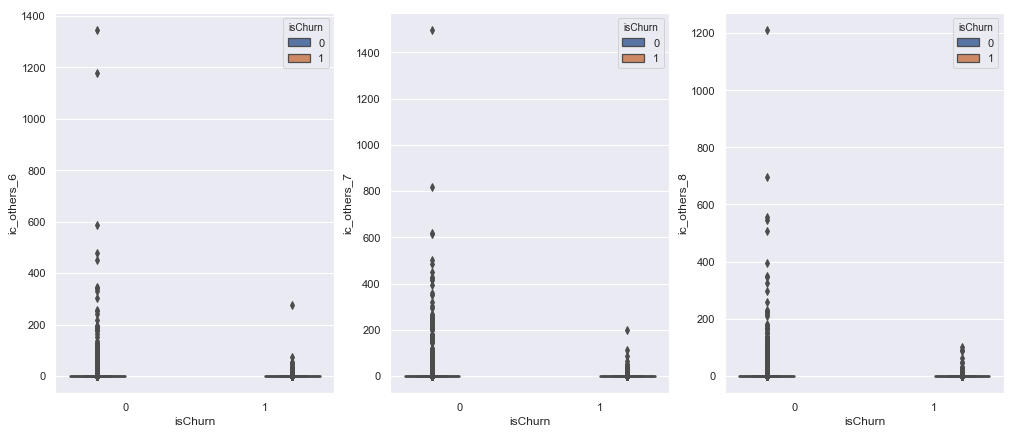

------------------------------------
total_rech
------------------------------------


median                mean                       std             
isChurn           0      1            0            1            0            1
total_rech_6  778.0  910.0  1109.651781  1193.936370  1592.341800  1229.422890
total_rech_7  824.0  687.0  1208.584619   964.583806  1650.000011  1396.272174
total_rech_8  396.0    0.0   838.180443   167.615141  1893.997612   633.576820

<Figure size 1224x504 with 0 Axes>

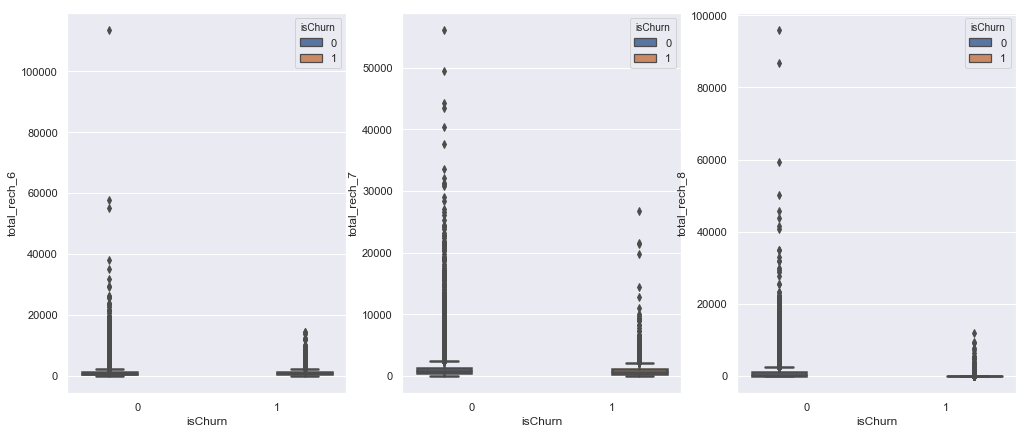

------------------------------------
std_ic_t2f_mou
------------------------------------


median           mean                  std           
isChurn               0    1         0         1          0          1
std_ic_t2f_mou_6    0.0  0.0  2.785836  1.679930  19.623822  11.605845
std_ic_t2f_mou_7    0.0  0.0  2.907939  1.562188  20.086436  11.112785
std_ic_t2f_mou_8    0.0  0.0  2.746710  0.476174  20.697955   4.903220

<Figure size 1224x504 with 0 Axes>

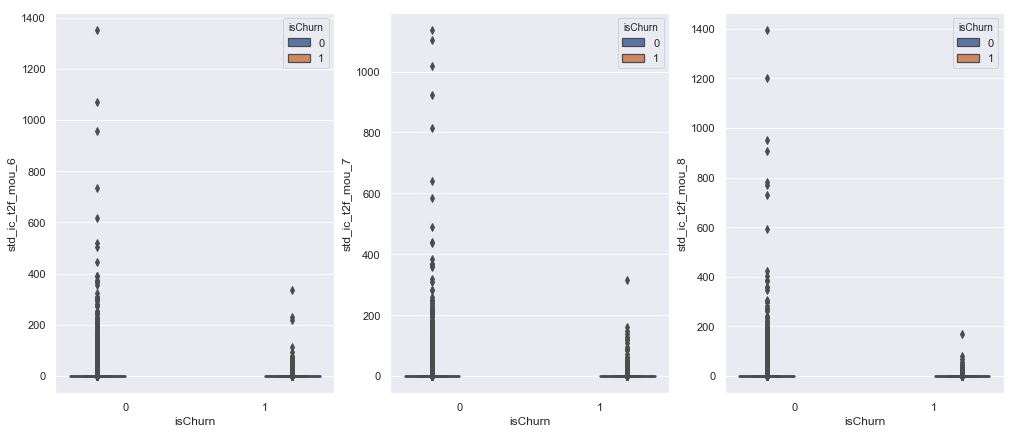

------------------------------------
last_day_rch_amt
------------------------------------


median            mean                     std            
isChurn                 0   1           0           1           0           1
last_day_rch_amt_6     67  50  100.586938  104.356002  140.808380  173.406733
last_day_rch_amt_7     65  30  102.275508   78.684146  139.566041  153.831374
last_day_rch_amt_8     50   0   97.416800   35.680049  145.528307  128.248857

<Figure size 1224x504 with 0 Axes>

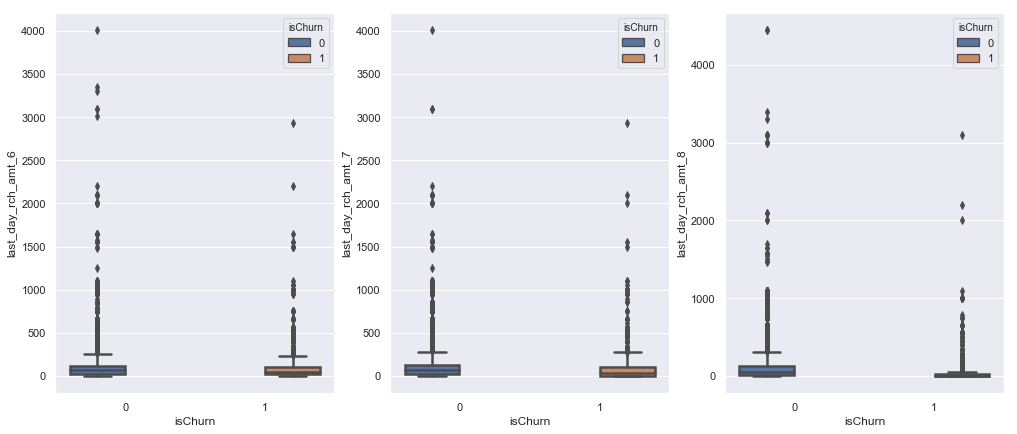

------------------------------------
loc_ic_t2t_mou
------------------------------------


median              mean                    std            
isChurn                0      1          0          1           0           1
loc_ic_t2t_mou_6  26.135  13.79  67.070515  47.194023  166.174078  131.848975
loc_ic_t2t_mou_7  27.385   9.81  69.382600  35.637079  172.177168   93.172164
loc_ic_t2t_mou_8  26.010   0.00  67.082278  12.231872  164.648047   39.207083

<Figure size 1224x504 with 0 Axes>

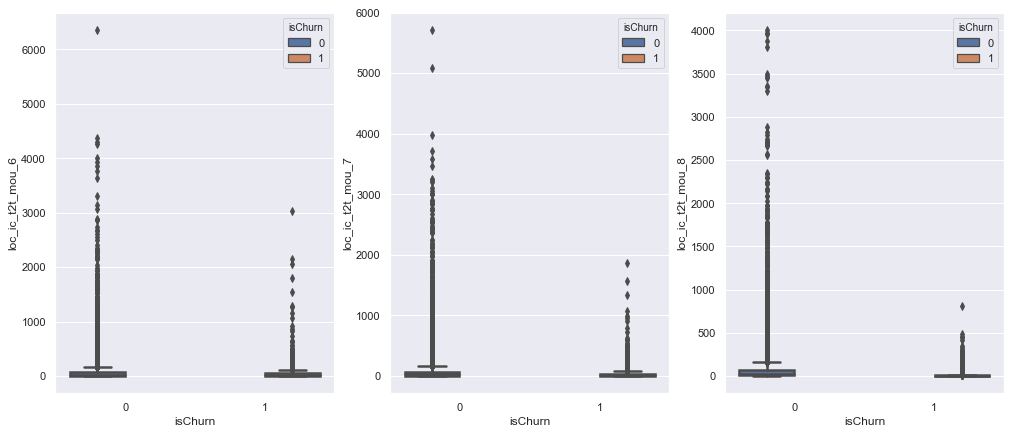

------------------------------------
loc_ic_mou
------------------------------------


median               mean                     std            
isChurn             0      1           0           1           0           1
loc_ic_mou_6  140.685  78.21  237.047212  164.614203  316.219224  290.460108
loc_ic_mou_7  146.435  56.98  243.720165  128.033146  320.606196  233.322305
loc_ic_mou_8  143.530   0.00  239.082589   44.673286  315.168020  110.022663

<Figure size 1224x504 with 0 Axes>

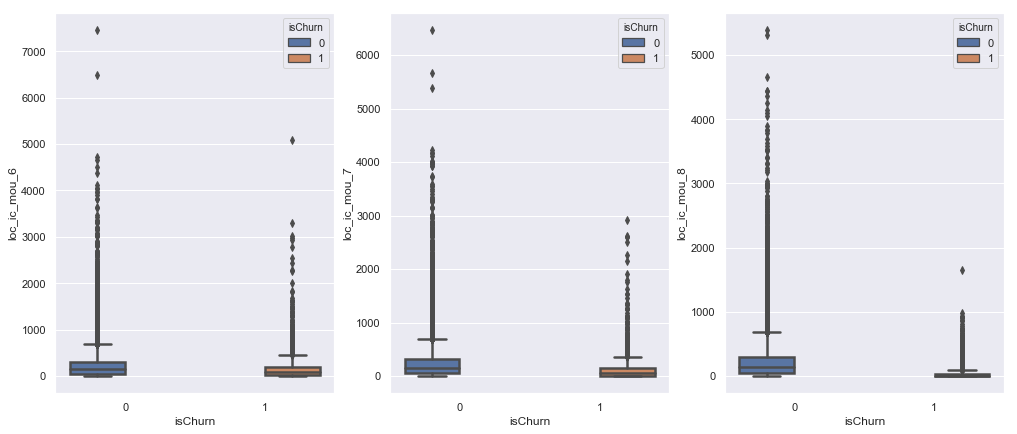

------------------------------------
spl_ic_mou
------------------------------------


median           mean                 std          
isChurn           0    1         0         1         0         1
spl_ic_mou_6    0.0  0.0  0.061055  0.060815  0.190248  0.161310
spl_ic_mou_7    0.0  0.0  0.020081  0.016190  0.188216  0.080625
spl_ic_mou_8    0.0  0.0  0.028472  0.005055  0.108626  0.129942

<Figure size 1224x504 with 0 Axes>

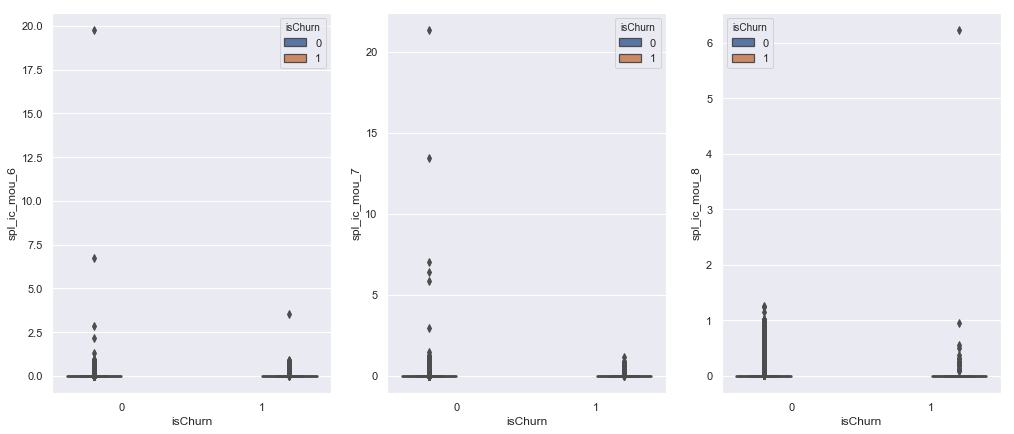

In [187]:

features = set()
for c in columns:
    if '_6' in c and ('date' not in c ) :
        features.add(c[:-2])
for f in features:
    analyze_feature(telecom,f,dict_outlier)

In [188]:
df2= telecom.copy()
telecom.shape

(30001, 150)

In [189]:
for k,v in dict_outlier.items():
    telecom = telecom[telecom[k] <= v] 

telecom.shape

(18863, 150)

In [190]:
telecom.corr().head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
arpu_6       1.000000  0.523900  0.441950     0.459697     0.284133   
arpu_7       0.523900  1.000000  0.643643     0.306263     0.466242   
arpu_8       0.441950  0.643643  1.000000     0.221501     0.324434   
onnet_mou_6  0.459697  0.306263  0.221501     1.000000     0.770745   
onnet_mou_7  0.284133  0.466242  0.324434     0.770745     1.000000   

             onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
arpu_6          0.257998      0.600411      0.382899      0.333165   
arpu_7          0.385361      0.385382      0.590796      0.479040   
arpu_8          0.493700      0.273264      0.405063      0.634266   
onnet_mou_6     0.663327      0.102264      0.057728      0.055333   
onnet_mou_7     0.809559      0.044253      0.104089      0.099422   

             roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
arpu_6            0.112872       0.099557       0.098333       0.172082   
arpu_7            0.092056       0.109504       0.104730       0.109132   
arpu_8            0.094209       0.062905       0.102912       0.108574   
onnet_mou_6       0.005084       0.058985       0.079040       0.061477   
onnet_mou_7       0.041945       0.017140       0.058137       0.086164   

             roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
arpu_6            0.126651       0.115719          0.321546          0.243248   
arpu_7            0.141724       0.130980          0.228263          0.335104   
arpu_8            0.068614       0.142474          0.229961          0.292746   
onnet_mou_6       0.104521       0.116827          0.284948          0.211036   
onnet_mou_7       0.063937       0.103691          0.181786          0.277132   

             loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
arpu_6               0.222602          0.458752          0.334324   
arpu_7               0.287239          0.312850          0.450552   
arpu_8               0.398915          0.311934          0.390549   
onnet_mou_6          0.170962          0.018625         -0.006919   
onnet_mou_7          0.208399         -0.031193          0.016248   

             loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
arpu_6               0.304784          0.198452          0.147039   
arpu_7               0.374377          0.142613          0.191940   
arpu_8               0.533755          0.169642          0.187414   
onnet_mou_6         -0.018539         -0.036707         -0.051517   
onnet_mou_7         -0.000514         -0.054586         -0.046600   

             loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  \
arpu_6               0.136204          0.058411         -0.014978   
arpu_7               0.159638          0.003308          0.049756   
arpu_8               0.244346         -0.012659          0.004522   
onnet_mou_6         -0.050825          0.021516          0.005491   
onnet_mou_7         -0.047443          0.011236          0.034293   

             loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  \
arpu_6               0.003265      0.485772      0.356915      0.320803   
arpu_7               0.032390      0.335510      0.483916      0.399527   
arpu_8               0.091156      0.336666      0.421314      0.565838   
onnet_mou_6          0.022402      0.137256      0.084660      0.055968   
onnet_mou_7          0.040343      0.054701      0.130603      0.084907   

             std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
arpu_6               0.361033          0.210940          0.191698   
arpu_7               0.235093          0.370889          0.304590   
arpu_8               0.144985          0.240014          0.381117   
onnet_mou_6          0.941679          0.727390          0.633330   
onnet_mou_7          0.733966          0.948293          0.776658   

             std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  \
arpu_6               0.389605          0.229146  

## Analysis on calls made by customer to call centre

In [191]:
# Filtering out columns related to call to customer care
t2c =list(filter(lambda x: 't2c' in x,telecom.columns))

In [192]:
t2c

['loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8']

In [193]:
# Adding "isChurn" variable to establish any relationship
t2c.append("isChurn")

In [194]:
t2c_df = telecom[t2c]

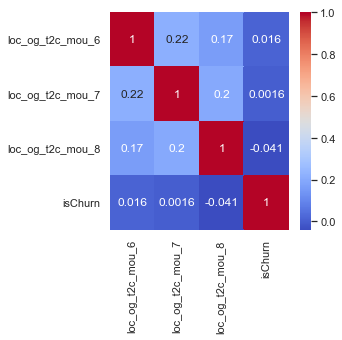

In [195]:
# Calculating Coorelation coefficient
sns.set(rc={'figure.figsize':(4,4)})
sns.heatmap(t2c_df.corr(), annot=True, cmap="coolwarm")

In [196]:
t2c_df_grouped = t2c_df.groupby("isChurn")
t2c_df_grouped['loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8'].agg(["sum","mean","median","max","min"])

loc_og_t2c_mou_6                              loc_og_t2c_mou_7  \
                     sum      mean median    max  min              sum   
isChurn                                                                  
0               17410.73  1.002172    0.0  24.94  0.0         19370.24   
1                1758.03  1.179886    0.0  24.46  0.0          1690.64   

                                     loc_og_t2c_mou_8                          \
             mean median    max  min              sum      mean median    max   
isChurn                                                                         
0        1.114962    0.0  27.78  0.0         19048.94  1.096468    0.0  28.21   
1        1.134658    0.0  27.98  0.0           904.02  0.606725    0.0  25.21   

              
         min  
isChurn       
0        0.0  
1        0.0

### Insights
1. Not much correlation is oberved so that we can drop one of the variable
2. Not able to verify fact that usually customers make more calls in action period to call centre, which is a sign of dissatisfaction with service

In [197]:
display(telecom["loc_og_t2c_mou_6"].describe())

count    18863.000000
mean         1.016210
std          3.050274
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         24.940000
Name: loc_og_t2c_mou_6, dtype: float64

## Analysis on AON

In [198]:
aon = telecom[["aon","isChurn"]]

In [199]:
telecom.pivot_table(values="aon", columns='isChurn', aggfunc=[np.median, np.mean, np.std, np.min, np.max])

median              mean                     std             amin  \
isChurn      0    1            0           1           0           1    0   
aon        893  607  1251.943073  857.230872  969.954364  740.266927  180   

              amax        
isChurn    1     0     1  
aon      180  4197  3651

In [200]:
aon = telecom.groupby("isChurn")

In [201]:
aon["aon"].quantile([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]).reset_index()

isChurn  level_1     aon
0         0      0.0   180.0
1         0      0.1   291.0
2         0      0.2   412.0
3         0      0.3   519.0
4         0      0.4   691.0
5         0      0.5   893.0
6         0      0.6  1174.2
7         0      0.7  1556.0
8         0      0.8  2301.0
9         0      0.9  2832.0
10        0      1.0  4197.0
11        1      0.0   180.0
12        1      0.1   241.0
13        1      0.2   324.0
14        1      0.3   397.7
15        1      0.4   488.0
16        1      0.5   607.0
17        1      0.6   742.4
18        1      0.7   922.0
19        1      0.8  1162.2
20        1      0.9  1944.7
21        1      1.0  3651.0

1. The average stay of customers, who are with company is more than the customers who churned. Naturally this should be present in any telecom data and so is with this dataset
2. Customers are taking minimum of 180 days before deciding to move away
3. Not much specific pattern was observed for customers who stayed for longer duration. 
4. We can say that monitoring of customers should start after 4-5 months of joining the network.

## ISD column

In [202]:
isd =list(filter(lambda x: 'isd' in x,telecom.columns))

In [203]:
#telecom.pivot_table(values=isd, columns='isChurn', aggfunc=[np.median, np.mean, np.std, np.min, np.max])

## Ananlysis on columns realted to internet

Filtering out all columns realted to internet on the base of keywords like 2g, 3g, data, fb

In [204]:
data = list(filter(lambda x: "data" in x, telecom.columns))

In [205]:
g2 = list(filter(lambda x: "2g" in x, telecom.columns))

In [206]:
g3 = list(filter(lambda x: "3g" in x, telecom.columns))

In [207]:
fb = list(filter(lambda x: "fb" in x, telecom.columns))

In [208]:
internet =data + g2 + g3 + fb
internet.append("isChurn")

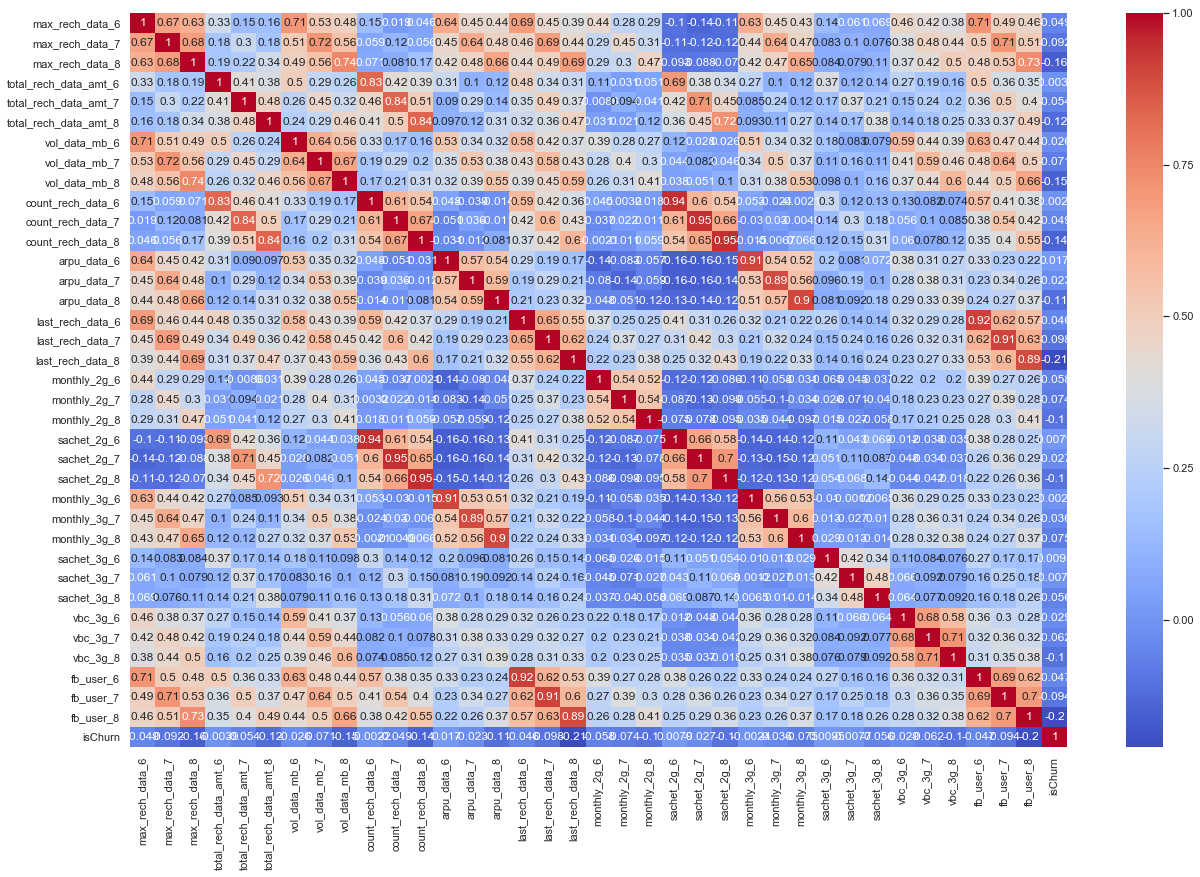

In [209]:
sns.set(rc={'figure.figsize':(21,13.5)})
sns.heatmap(telecom[internet].corr(), annot=True, cmap = "coolwarm")

### Insights
1. Most of the columns with _6,_7,_8 are coorelated among themselves
2. In few columns we can see that correlation coeeficent is as high as .9
3. We can use this plot to drop some variables, like columns fb_user_6 has .91 correlation value with last_rech_data_6 and column 7, 8 also shows same relationship
4. "isChurn" column doesn't shows any particular realtion

## Correlation Analysis

As number of variables of much more, lets diivide coorelation analysis in two parts that are negative and positive

In [210]:
# Top 50 pairs for positive correlation
telecom.corr().unstack().sort_values(ascending=False).drop_duplicates()[:50]

last_rech_8            last_rech_8              1.000000
loc_ic_mou_8           total_ic_mou_8           0.970428
total_ic_mou_6         loc_ic_mou_6             0.968878
loc_ic_mou_7           total_ic_mou_7           0.965685
total_rech_amt_8       arpu_8                   0.954687
count_rech_data_8      sachet_2g_8              0.948844
std_og_t2t_mou_7       onnet_mou_7              0.948293
count_rech_data_7      sachet_2g_7              0.947255
onnet_mou_8            std_og_t2t_mou_8         0.946138
sachet_2g_6            count_rech_data_6        0.943978
total_rech_amt_6       arpu_6                   0.943511
std_og_t2t_mou_6       onnet_mou_6              0.941679
total_rech_amt_7       arpu_7                   0.941293
loc_ic_mou_8           loc_ic_t2m_mou_8         0.940101
loc_ic_t2m_mou_7       loc_ic_mou_7             0.931819
loc_ic_t2m_mou_6       loc_ic_mou_6             0.930641
loc_og_t2m_mou_8       loc_og_mou_8             0.924619
std_ic_t2m_mou_8       std_ic_m

In [211]:
# Top 20 pairs for negative coorelation
telecom.corr().unstack().sort_values().drop_duplicates()[:20]

total_og_mou_7    fb_user_6          -0.517872
fb_user_7         total_og_mou_6     -0.506375
total_og_mou_7    fb_user_7          -0.498349
total_og_mou_6    fb_user_6          -0.483826
last_rech_data_6  total_og_mou_7     -0.475778
last_rech_data_7  total_og_mou_6     -0.467692
std_og_mou_7      fb_user_6          -0.450868
total_og_mou_7    last_rech_data_7   -0.450452
fb_user_7         std_og_mou_6       -0.445277
last_rech_data_6  total_og_mou_6     -0.437429
fb_user_7         std_og_mou_7       -0.434858
total_og_mou_8    fb_user_6          -0.434640
fb_user_6         std_og_mou_6       -0.429627
total_og_mou_6    fb_user_8          -0.425549
total_og_mou_7    fb_user_8          -0.416586
std_og_mou_7      last_rech_data_6   -0.414517
total_og_mou_8    fb_user_7          -0.413440
last_rech_data_7  std_og_mou_6       -0.412432
max_rech_amt_6    total_rech_num_7   -0.401746
fb_user_6         offnet_mou_7       -0.396668
dtype: float64

### Insights
1. The negative coorelation doesn't give enough evidnce to drop some varibales directly. But it can be used later
2. The positive correlation value gave many strong relationships.
3. We can use few values to drop variables.
4. Columns with name "arpu" and "amt" shows strong realtionship, lets dig them further

## Relationship between columns "arpu" and "amount"

In [212]:
# Filtering out columns with name "arpu"
arpu = list(filter(lambda x: "arpu" in x, telecom.columns))

In [213]:
# Filtering out columns with name "amt"
amt = list(filter(lambda x: "amt" in x, telecom.columns))

In [214]:
arpu_amt = arpu+amt

In [215]:
arpu_amt.append("isChurn")

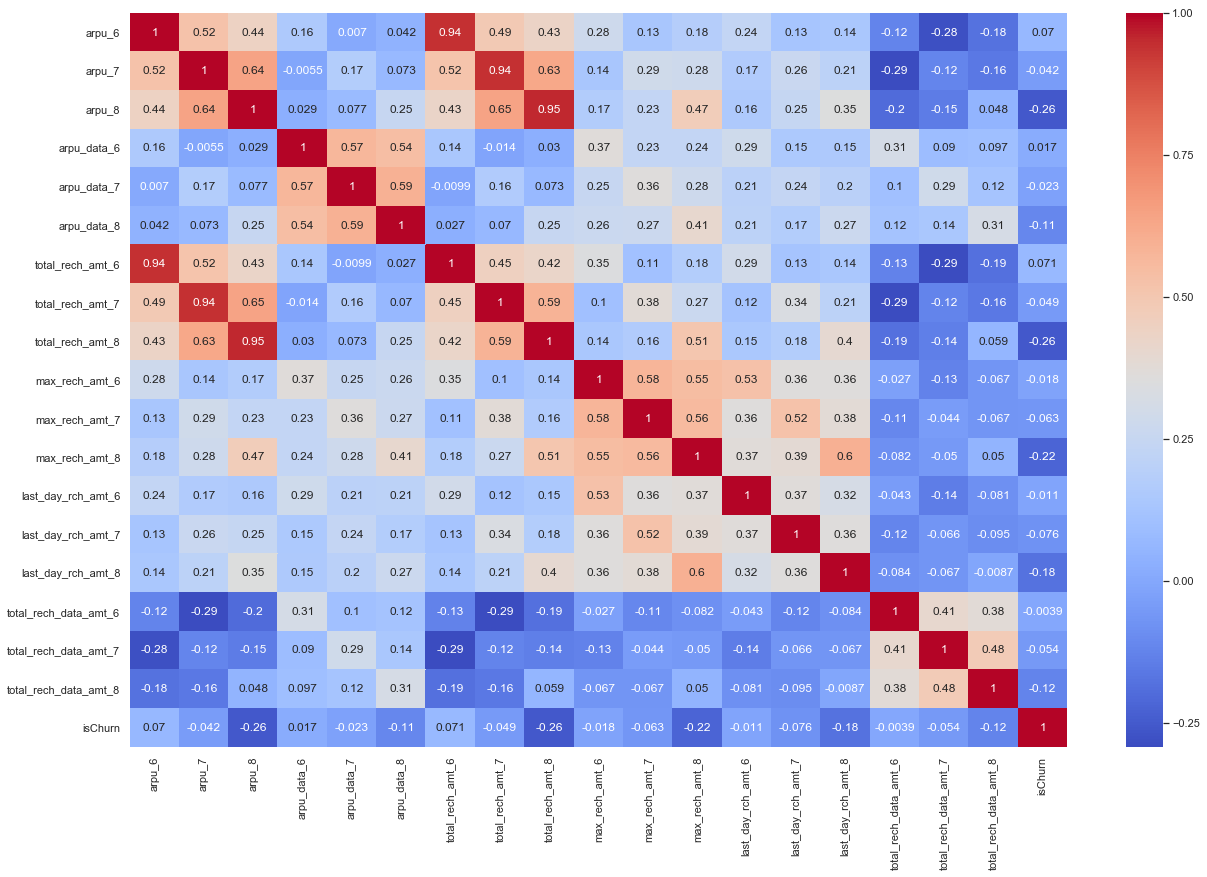

In [216]:
sns.heatmap(telecom[arpu_amt].corr(), annot = True, cmap="coolwarm")

### Handling Class Imbalance

In [217]:
telecom.shape

(18863, 150)

In [218]:
telecom['isChurn'].value_counts()


0    17373
1     1490
Name: isChurn, dtype: int64

In [219]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(telecom, test_size=0.3, random_state=0)

print("Number transactions df_train dataset: ", df_train.shape)
print("Number transactions df_train dataset: ", df_train.shape)


Number transactions df_train dataset:  (13204, 150)
Number transactions df_train dataset:  (13204, 150)


### Rescaling

In [220]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_vars =df_train.select_dtypes(include=numerics).columns

In [221]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [222]:
# Spliting x and y variables
y_train = df_train.pop('isChurn')
X_train = df_train

y_test = df_test.pop('isChurn')
X_test = df_test


In [223]:
type(y_train)

pandas.core.series.Series

In [224]:
print("Before OverSampling, counts of label '1': {}".format(y_train.value_counts()[1]))
print("Before OverSampling, counts of label '0': {} \n".format(y_train.value_counts()[0]))

Before OverSampling, counts of label '1': 1008
Before OverSampling, counts of label '0': 12196 



In [225]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0.0: 12196, 1.0: 12196})


In [226]:
X_res = pd.DataFrame(data=X_res, columns=X_train.columns) 


In [227]:
print('X_res.shape {} , y_res.shape {} '.format(X_res.shape,y_res.shape))
print('X_train.shape {} , y_train.shape {} '.format(X_train.shape,y_train.shape))
print('X_test.shape {} , y_test.shape {} '.format(X_test.shape,y_test.shape))

X_res.shape (24392, 149) , y_res.shape (24392,) 
X_train.shape (13204, 149) , y_train.shape (13204,) 
X_test.shape (5659, 149) , y_test.shape (5659,) 


In [228]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

Counter({0.0: 12196, 1.0: 12196})

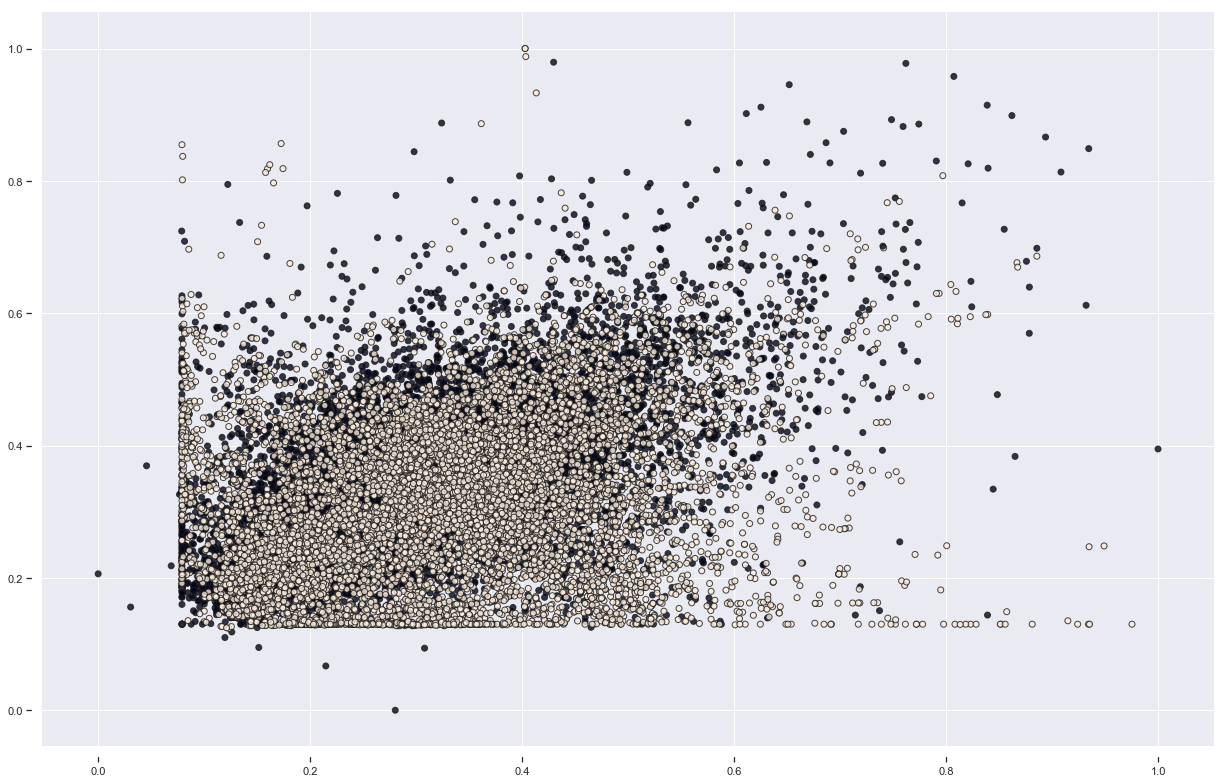

In [229]:
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

plot_resampling(X_train, y_train, smote, ax)

# Model Building

## Logistic Regression

In [230]:
import statsmodels.api as sm

Functions to implement Algorithms

In [231]:
def optimal_cutoff(y_train_pred_final):
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1

        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    plt.figure(figsize=(5, 5))
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()

#Plotting the ROC Curve

def draw_roc( actual, probs ):
    
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


def VIF(X_train, col) :
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif = pd.DataFrame()
    vif['Features'] = X_train[col].columns
    vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

def model_performance(y_train_pred_final):
    confusion = metrics.confusion_matrix(y_train_pred_final.Churn,y_train_pred_final.predicted)
    print('Confusion Matrix :')
    print(confusion)
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    
    sensitivity = round(float(TP / (TP + FN)),2)
    specificity = round(float(TN / (TN + FP)),2)

    precision = round(float(TP / (TP + FP)),2)
    recall = sensitivity
#     print('AUC Score:{2.2f}'.format(metrics.roc_auc_score(y_train_pred_final.Churn, y_train_pred_final.predicted)))
#     print('F1 Score: {2.2f}'.format(metrics.f1_score(y_train_pred_final.Churn, y_train_pred_final.predicted)))
    print('==='*12)
    print('accuracy score: {} '.format(round(metrics.accuracy_score(y_train_pred_final.Churn,y_train_pred_final.predicted),2)))
    print('sensitivity : {}'.format(sensitivity))
    print('specificity :{}'.format(specificity))
#     print('precision : {}'.format(precision))
#     print('recall : {}'.format(recall))
    print('==='*12)
   

from sklearn import metrics

def logistic_regression(X_train,y_train,X_test,y_test, col, cut_off=0.5):
    X_test_sm =  sm.add_constant(X_test[col])
    X_train_sm = sm.add_constant(X_train[col])
    log_m1=sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
    res = log_m1.fit()
    
    print(res.summary())
    y_train_pred = res.predict(X_train_sm)
    y_train_pred_final=pd.DataFrame({'Churn':y_train, 'Churn_Prob': y_train_pred })
    y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > cut_off else 0)

    
    
    draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)
    print('VIF------------->')
    display(VIF(X_train,col))
    optimal_cutoff(y_train_pred_final)
    
    print('Result on Training Data')
    model_performance(y_train_pred_final)
    print('-----'*3)
    return res
    # logistic_regression(X_train, y_train,X_test,y_test,list(X_train.columns))

def rfe(X_train,y_train,num):
    from sklearn.linear_model import LogisticRegression
    from sklearn.feature_selection import RFE
    log_reg = LogisticRegression(solver='liblinear')
    rfe = RFE(log_reg, num)
    rfe=rfe.fit(X_train,y_train)
    col =X_train.columns[rfe.support_]
    return col

def SVM (X_train,y_train,C=1,gamma=0.1,kernel='rbf'):
    from sklearn.svm import SVC
    svm_model = SVC(C=C, gamma=gamma, kernel=kernel)
    svm_model.fit(X_train, y_train)
    
    y_train_pred = svm_model.predict(X_train)
    #create dataframe
    y_train_pred_final=pd.DataFrame({'Churn':y_train, 'predicted': y_train_pred })
    model_performance(y_train_pred_final)
    return svm_model

def svm_hyper_parameter_tuning(X_train,y_train,n_split=5,kernel='rbf'):
    from sklearn.svm import SVC
    from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
    
    folds = KFold(n_splits = n_split, shuffle = True, random_state = 101)
    hyperparameters =[{'gamma': [0.1, 0.01] , 'C':[1,10,100]}]
    
    model=SVC(kernel='rbf')
    
    model_cv = GridSearchCV(estimator=model, param_grid=hyperparameters, n_jobs=4,
                            scoring='recall',cv=folds,verbose=1,return_train_score=True)
    model_cv.fit(X_train,y_train)
    cv_results = pd.DataFrame(model_cv.cv_results_)
    
    # converting C to numeric type for plotting on x-axis
    cv_results['param_C'] = cv_results['param_C'].astype('int')

    # # plotting
    plt.figure(figsize=(16,6))

    # subplot 1/3
    plt.subplot(131)
    gamma_01 = cv_results[cv_results['param_gamma']==0.01]

    plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
    plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title("Gamma=0.01")
    plt.ylim([0.60, 1])
    plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
    plt.xscale('log')

    # subplot 2/3
    plt.subplot(132)
    gamma_001 = cv_results[cv_results['param_gamma']==0.001]

    plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
    plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title("Gamma=0.001")
    plt.ylim([0.60, 1])
    plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
    plt.xscale('log')


    # subplot 3/3
    plt.subplot(133)
    gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

    plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
    plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title("Gamma=0.0001")
    plt.ylim([0.60, 1])
    plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
    plt.xscale('log')

    
    # printing the optimal accuracy score and hyperparameters
    best_score = model_cv.best_score_
    best_hyperparams = model_cv.best_params_

    print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))
    
    
    
    

#### Applying Logistic Regression with 20 Variables

In [232]:
col = rfe(X_res,y_res,20)
print(col)

Index(['arpu_8', 'loc_og_mou_8', 'std_og_t2f_mou_8', 'total_og_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2f_mou_7',
       'std_ic_t2f_mou_8', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_8',
       'total_rech_num_8', 'last_day_rch_amt_8', 'monthly_2g_8', 'sachet_2g_8',
       'monthly_3g_8', 'vol_data_mb_8', 'arpu_data_8', 'vbc_3g_8'],
      dtype='object')


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24392
Model:                            GLM   Df Residuals:                    24371
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8919.3
Date:                Mon, 19 Aug 2019   Deviance:                       17839.
Time:                        07:44:21   Pearson chi2:                 4.91e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3933      0.045     53.549      0.000       2.306       2.481
arpu_8                 5.631

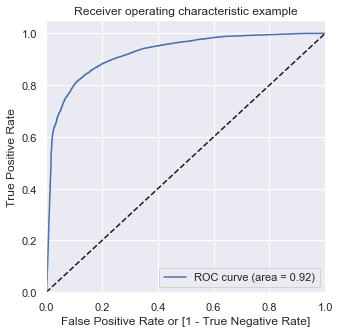

VIF------------->


Features    VIF
6         loc_ic_mou_8  71.60
10      total_ic_mou_8  55.77
5         loc_ic_mou_7  46.26
9       total_ic_mou_7  45.49
4     loc_ic_t2m_mou_8  14.91
0               arpu_8  14.66
18         arpu_data_8   9.11
16        monthly_3g_8   6.17
3       total_og_mou_8   5.39
12    total_rech_num_8   4.52
17       vol_data_mb_8   3.95
1         loc_og_mou_8   3.83
13  last_day_rch_amt_8   2.30
14        monthly_2g_8   1.91
19            vbc_3g_8   1.85
15         sachet_2g_8   1.59
8     std_ic_t2f_mou_8   1.38
7     std_ic_t2f_mou_7   1.35
2     std_og_t2f_mou_8   1.15
11        spl_ic_mou_8   1.07

<Figure size 360x360 with 0 Axes>

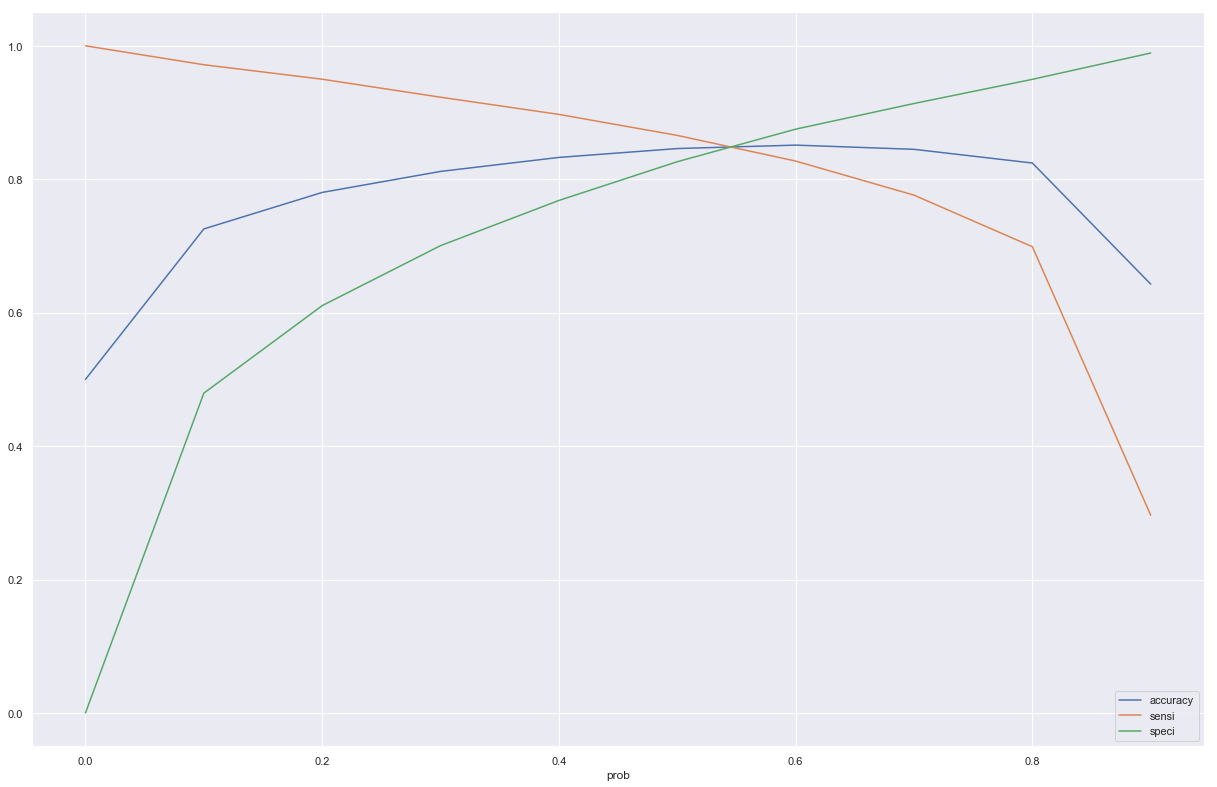

Result on Training Data
Confusion Matrix :
[[10077  2119]
 [ 1638 10558]]
accuracy score: 0.85 
sensitivity : 0.87
specificity :0.83
---------------


In [233]:

log_model = logistic_regression(X_res, y_res,X_test,y_test,col)

In [234]:
print(X_test[col].shape)
print(X_res[col].shape)
X_test_sm =  sm.add_constant(X_test[col])
y_test_pred = log_model.predict(X_test_sm)
y_test_pred_final=pd.DataFrame({'Churn':y_test, 'Churn_Prob': y_test_pred })
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

print('Result on Test Data')
model_performance(y_test_pred_final)



(5659, 20)
(24392, 20)
Result on Test Data
Confusion Matrix :
[[4271  906]
 [  73  409]]
accuracy score: 0.83 
sensitivity : 0.85
specificity :0.82


reducing the model variabls to 15

In [235]:
col15 = rfe(X_res,y_res,15)
print(col15)


Index(['std_og_t2f_mou_8', 'total_og_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2f_mou_8', 'total_ic_mou_7',
       'total_ic_mou_8', 'spl_ic_mou_8', 'last_day_rch_amt_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'vol_data_mb_8', 'arpu_data_8'],
      dtype='object')


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24392
Model:                            GLM   Df Residuals:                    24376
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9167.6
Date:                Mon, 19 Aug 2019   Deviance:                       18335.
Time:                        07:46:49   Pearson chi2:                 4.54e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3130      0.041     56.788      0.000       2.233       2.393
std_og_t2f_mou_8      -4.924

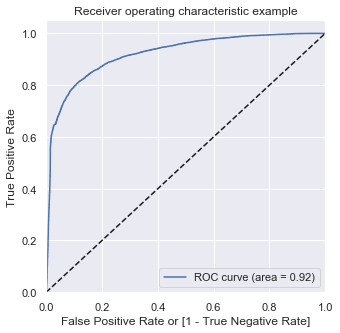

VIF------------->


Features    VIF
4         loc_ic_mou_8  69.35
7       total_ic_mou_8  55.50
3         loc_ic_mou_7  45.48
6       total_ic_mou_7  44.03
2     loc_ic_t2m_mou_8  14.87
14         arpu_data_8   7.80
12        monthly_3g_8   5.95
13       vol_data_mb_8   3.33
1       total_og_mou_8   1.98
9   last_day_rch_amt_8   1.93
10        monthly_2g_8   1.80
11         sachet_2g_8   1.26
5     std_ic_t2f_mou_8   1.19
0     std_og_t2f_mou_8   1.13
8         spl_ic_mou_8   1.06

<Figure size 360x360 with 0 Axes>

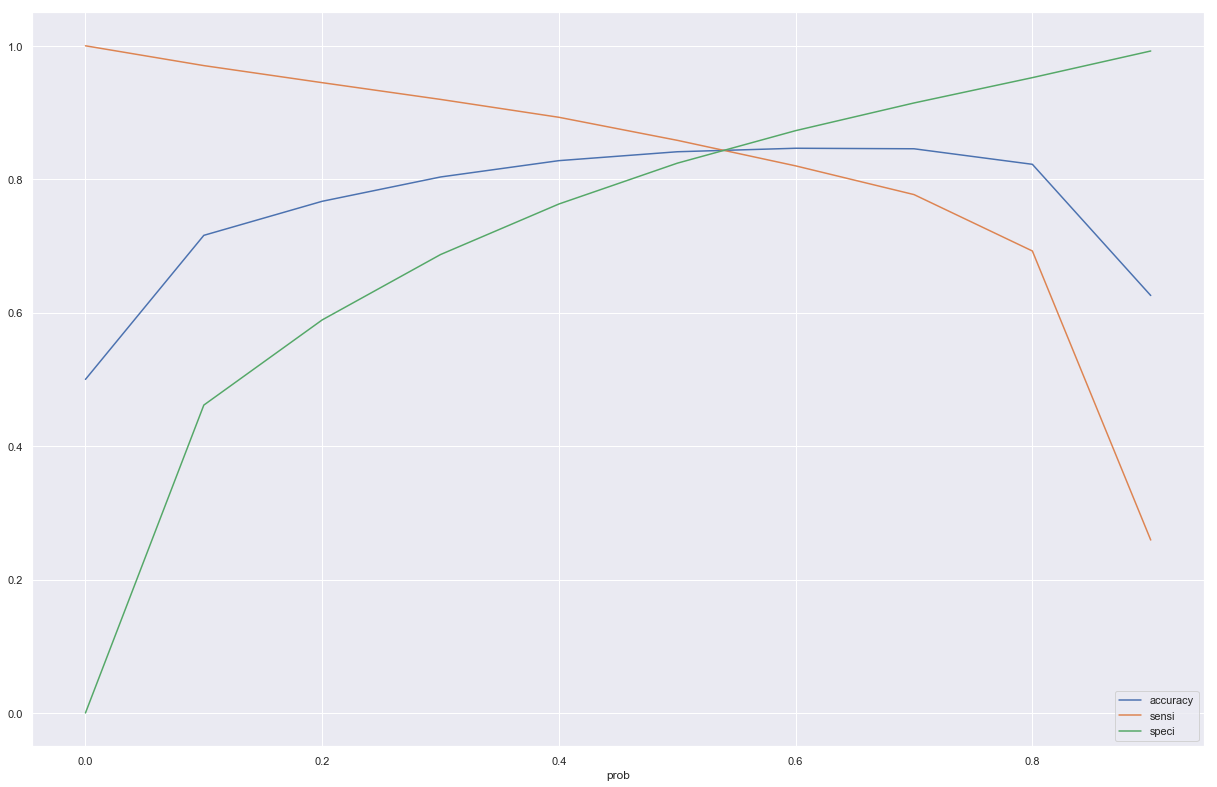

Result on Training Data
Confusion Matrix :
[[10050  2146]
 [ 1728 10468]]
accuracy score: 0.84 
sensitivity : 0.86
specificity :0.82
---------------


In [236]:

logistic_regression(X_res, y_res,X_test,y_test,col15)

In [237]:
col15=list(col15)
col15.remove('loc_ic_t2m_mou_8')
print(col15)

['std_og_t2f_mou_8', 'total_og_mou_8', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2f_mou_8', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_8', 'last_day_rch_amt_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'vol_data_mb_8', 'arpu_data_8']


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24392
Model:                            GLM   Df Residuals:                    24377
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9190.6
Date:                Mon, 19 Aug 2019   Deviance:                       18381.
Time:                        07:47:02   Pearson chi2:                 4.53e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3090      0.041     56.751      0.000       2.229       2.389
std_og_t2f_mou_8      -4.976

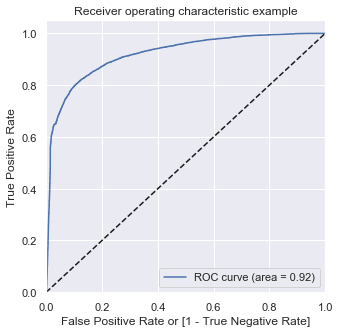

VIF------------->


Features    VIF
6       total_ic_mou_8  55.49
3         loc_ic_mou_8  53.75
2         loc_ic_mou_7  45.45
5       total_ic_mou_7  44.01
13         arpu_data_8   7.80
11        monthly_3g_8   5.95
12       vol_data_mb_8   3.33
1       total_og_mou_8   1.97
8   last_day_rch_amt_8   1.93
9         monthly_2g_8   1.80
10         sachet_2g_8   1.26
4     std_ic_t2f_mou_8   1.19
0     std_og_t2f_mou_8   1.13
7         spl_ic_mou_8   1.06

<Figure size 360x360 with 0 Axes>

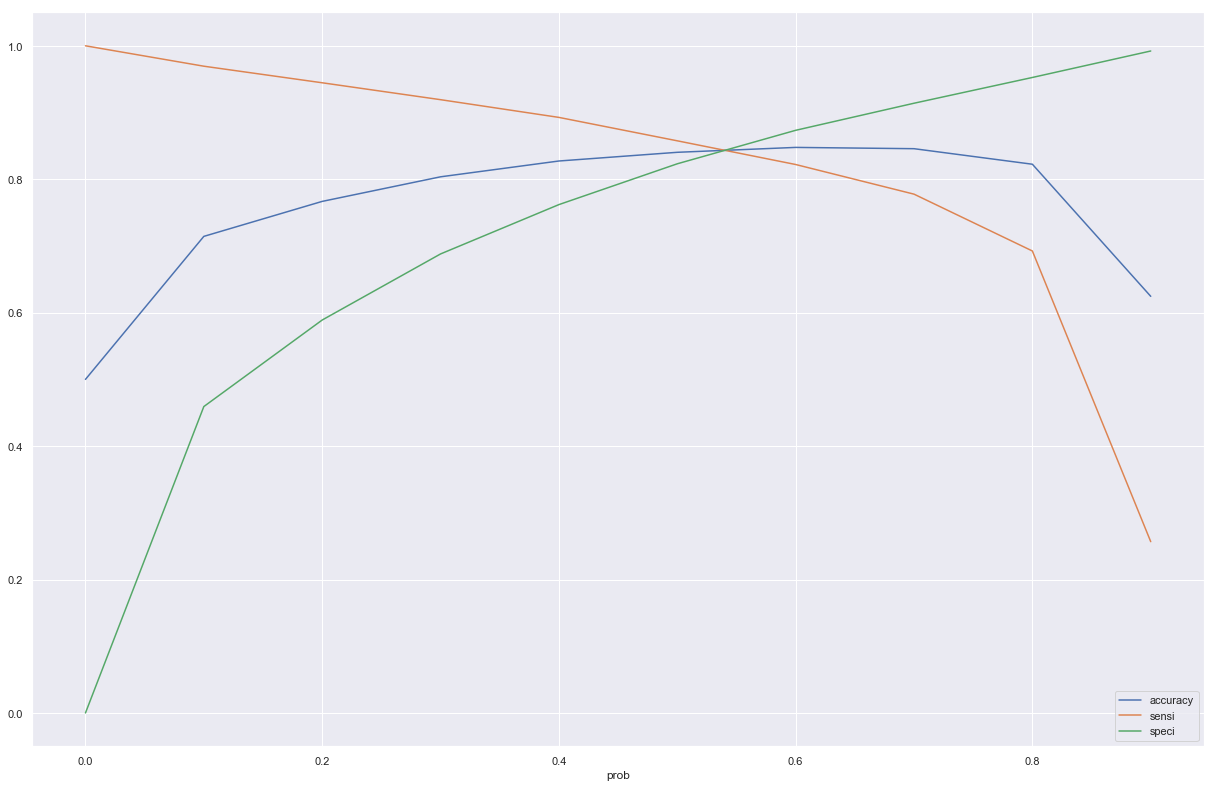

Result on Training Data
Confusion Matrix :
[[10039  2157]
 [ 1737 10459]]
accuracy score: 0.84 
sensitivity : 0.86
specificity :0.82
---------------


In [238]:
model=logistic_regression(X_res, y_res,X_test,y_test,col15)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24392
Model:                            GLM   Df Residuals:                    24378
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9223.7
Date:                Mon, 19 Aug 2019   Deviance:                       18447.
Time:                        07:47:18   Pearson chi2:                 4.63e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3247      0.041     57.240      0.000       2.245       2.404
std_og_t2f_mou_8      -5.233

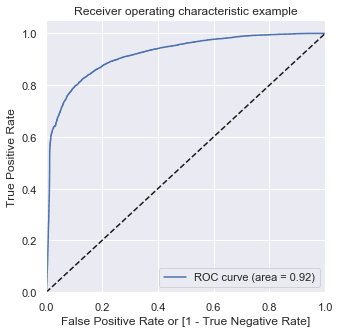

VIF------------->


Features    VIF
2         loc_ic_mou_7  30.67
5       total_ic_mou_7  28.09
12         arpu_data_8   7.79
10        monthly_3g_8   5.95
3         loc_ic_mou_8   4.82
11       vol_data_mb_8   3.33
7   last_day_rch_amt_8   1.93
1       total_og_mou_8   1.88
8         monthly_2g_8   1.80
9          sachet_2g_8   1.26
4     std_ic_t2f_mou_8   1.18
0     std_og_t2f_mou_8   1.12
6         spl_ic_mou_8   1.06

<Figure size 360x360 with 0 Axes>

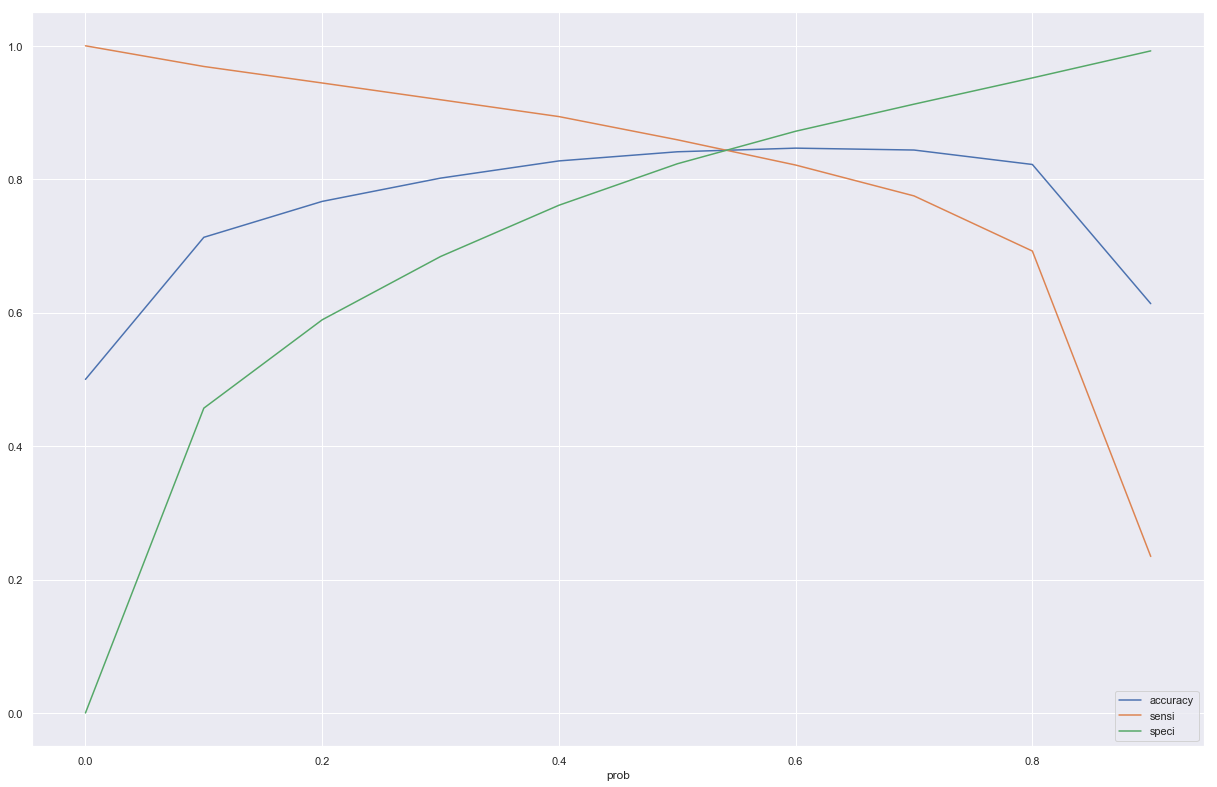

Result on Training Data
Confusion Matrix :
[[10039  2157]
 [ 1718 10478]]
accuracy score: 0.84 
sensitivity : 0.86
specificity :0.82
---------------


In [239]:
col15.remove('total_ic_mou_8')
logistic_regression(X_res, y_res,X_test,y_test,col15)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24392
Model:                            GLM   Df Residuals:                    24379
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9224.6
Date:                Mon, 19 Aug 2019   Deviance:                       18449.
Time:                        07:47:25   Pearson chi2:                 4.61e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.3136      0.040     58.337      0.000       2.236       2.391
std_og_t2f_mou_8      -5.273

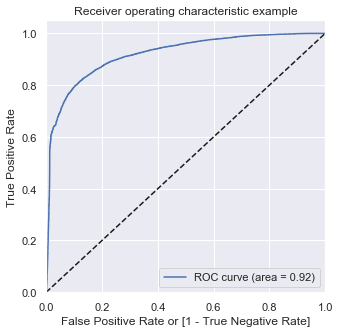

VIF------------->


Features   VIF
11         arpu_data_8  7.70
9         monthly_3g_8  5.91
3         loc_ic_mou_8  4.72
2         loc_ic_mou_7  4.15
10       vol_data_mb_8  3.33
6   last_day_rch_amt_8  1.93
7         monthly_2g_8  1.80
1       total_og_mou_8  1.78
8          sachet_2g_8  1.25
4     std_ic_t2f_mou_8  1.17
0     std_og_t2f_mou_8  1.12
5         spl_ic_mou_8  1.06

<Figure size 360x360 with 0 Axes>

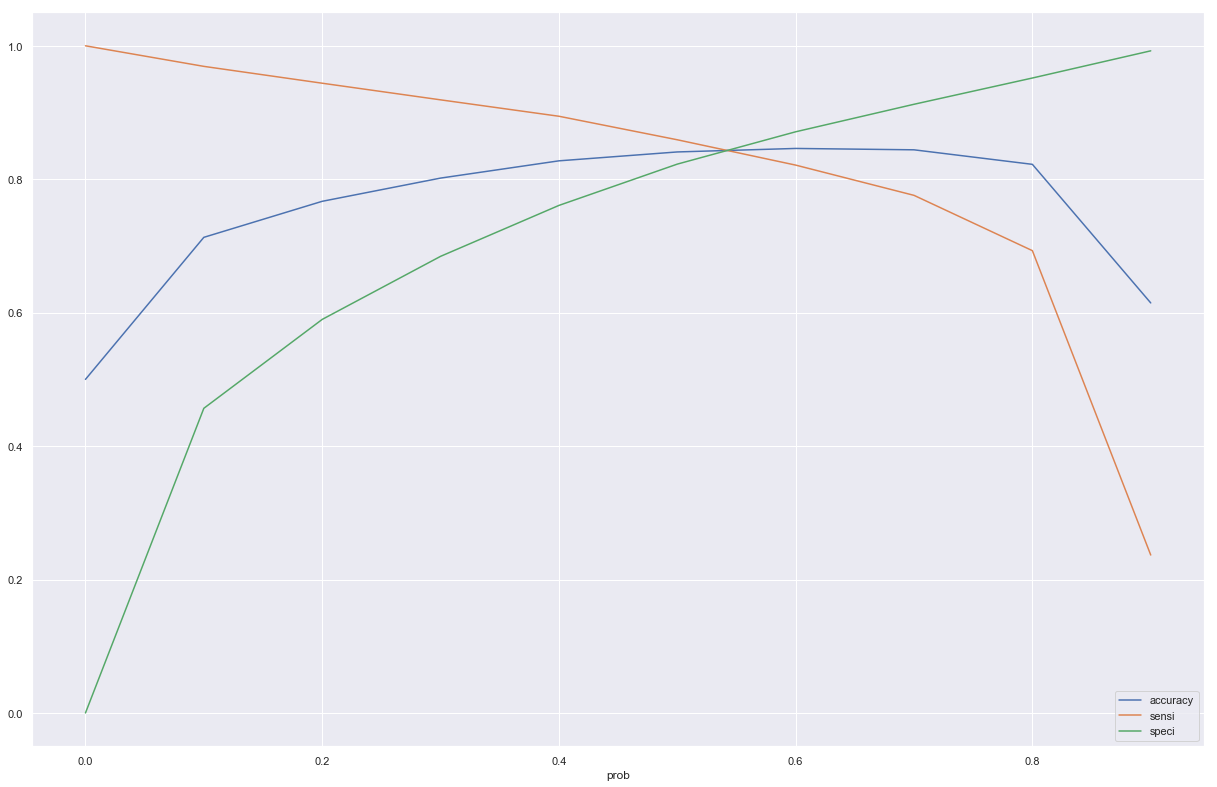

Result on Training Data
Confusion Matrix :
[[10033  2163]
 [ 1718 10478]]
accuracy score: 0.84 
sensitivity : 0.86
specificity :0.82
---------------


In [240]:
col15.remove('total_ic_mou_7')
logistic_regression(X_res, y_res,X_test,y_test,col15)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24392
Model:                            GLM   Df Residuals:                    24380
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9542.4
Date:                Mon, 19 Aug 2019   Deviance:                       19085.
Time:                        07:47:31   Pearson chi2:                 4.62e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.8042      0.031     58.244      0.000       1.743       1.865
std_og_t2f_mou_8      -5.353

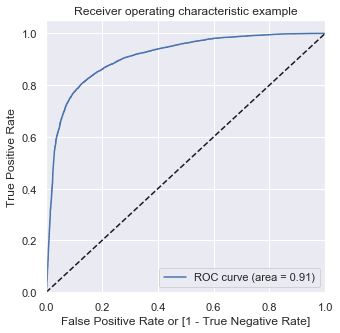

VIF------------->


Features   VIF
3         loc_ic_mou_8  4.72
2         loc_ic_mou_7  4.06
10       vol_data_mb_8  3.00
9         monthly_3g_8  2.16
6   last_day_rch_amt_8  1.84
7         monthly_2g_8  1.75
1       total_og_mou_8  1.73
8          sachet_2g_8  1.25
4     std_ic_t2f_mou_8  1.17
0     std_og_t2f_mou_8  1.12
5         spl_ic_mou_8  1.06

<Figure size 360x360 with 0 Axes>

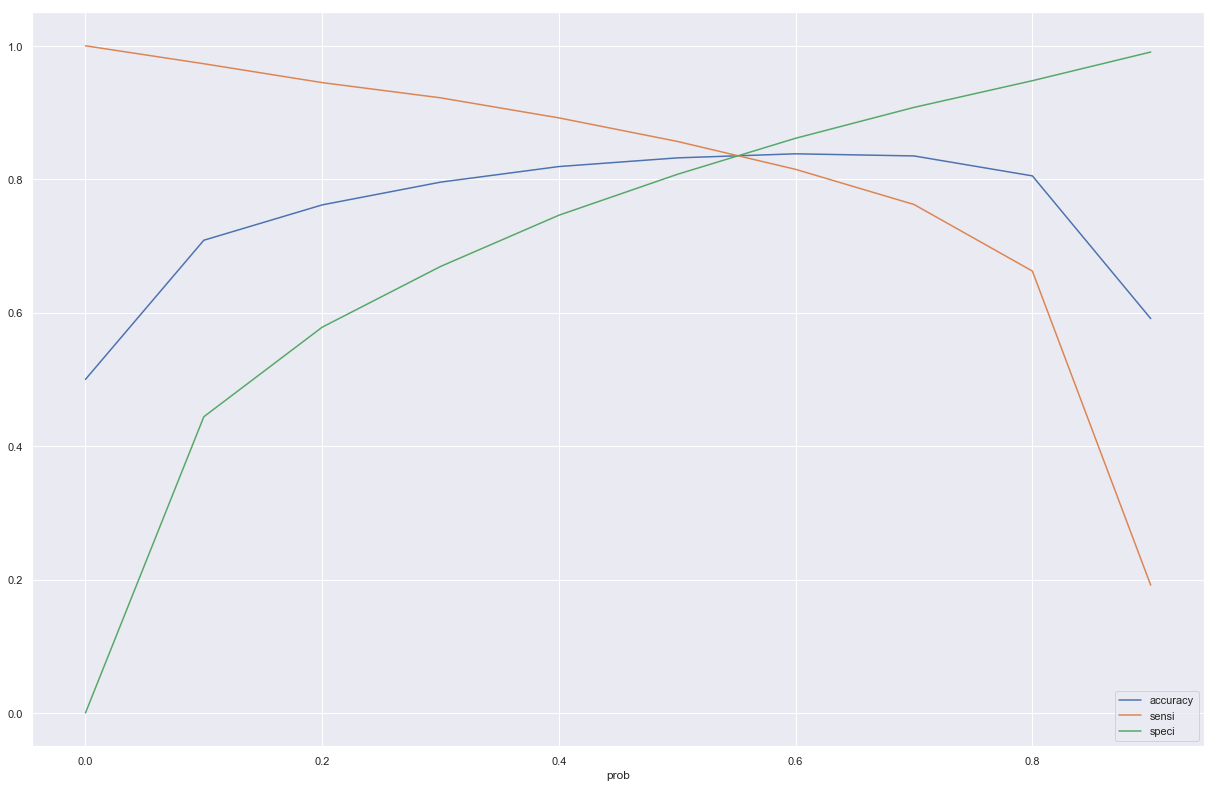

Result on Training Data
Confusion Matrix :
[[ 9846  2350]
 [ 1748 10448]]
accuracy score: 0.83 
sensitivity : 0.86
specificity :0.81
---------------


In [241]:

col15.remove('arpu_data_8')
logistic_regression(X_res, y_res,X_test,y_test,col15)

## PCA Implementation

In [242]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)
X_res = pd.DataFrame(X_res, columns=X_train.columns)
print(pca.fit(X_res))
print(pca.components_)
print(pca.explained_variance_)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)
[[-4.79214866e-02 -3.29793545e-02 -5.05121745e-03 ...  9.28913054e-05
   2.77429406e-03  8.74609365e-03]
 [ 3.76266306e-02  1.06697427e-01  1.66214647e-01 ... -1.58602915e-03
   2.17582065e-02  1.52326413e-01]
 [ 9.68917700e-02  3.49774078e-02  7.64375137e-02 ...  9.36339794e-03
  -1.32764666e-02 -9.90138537e-02]
 ...
 [-0.00000000e+00  1.37628384e-16 -3.59994311e-17 ... -2.22884418e-17
  -6.42378003e-18 -3.46452748e-17]
 [-0.00000000e+00 -1.60494080e-18 -5.00985901e-17 ... -6.74679634e-17
   5.84724219e-17 -7.64091520e-17]
 [ 0.00000000e+00 -6.92574133e-17 -4.23869811e-17 ... -1.72130820e-16
  -3.68782536e-17 -2.06685777e-17]]
[1.20709326e+00 3.59318744e-01 2.20986019e-01 1.83654097e-01
 1.55489846e-01 1.42489297e-01 9.55456437e-02 7.71328377e-02
 7.43590618e-02 5.08275143e-02 4.67991563e-02 4.22108591e-02
 3.75837500e-02 3.59332404e-02 3.56990675e-02 3.1867171

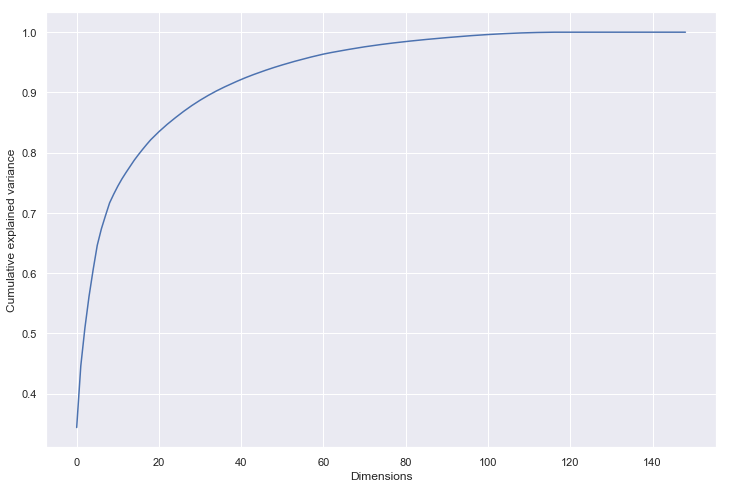

In [243]:
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.title('Scree Plot')
plt.xlabel('Dimensions')
plt.ylabel('Cumulative explained variance')
plt.show()

#### Selecting 40 components as it is expalining ~92% of variance

In [244]:
def func_PCA(num_comp,X_train_data, X_test_data):
    from sklearn.decomposition import IncrementalPCA
    #Selecting number of components
    pca_final = IncrementalPCA(n_components=num_comp,)
    nd_train_pca = pca_final.fit_transform(X_train_data)
    nd_test_pca = pca_final.transform(X_test_data)

    df_X_pca_train=pd.DataFrame(data=nd_train_pca, columns= ['PC{}'.format(i) for i in range(1,num_comp+1)])
    df_X_pca_test=pd.DataFrame(data=nd_test_pca, columns= ['PC{}'.format(i) for i in range(1,num_comp+1)])
    return (df_X_pca_train,df_X_pca_test)

In [245]:
df_X_pca_train, df_X_pca_test=func_PCA(40,X_res,X_test)

In [246]:
df_X_pca_test.shape

(5659, 40)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24392
Model:                            GLM   Df Residuals:                    24351
Model Family:                Binomial   Df Model:                           40
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9237.2
Date:                Mon, 19 Aug 2019   Deviance:                       18474.
Time:                        07:50:43   Pearson chi2:                 3.24e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2486      0.022    -11.435      0.000      -0.291      -0.206
PC1           -0.7834      0.019    -42.239      0.0

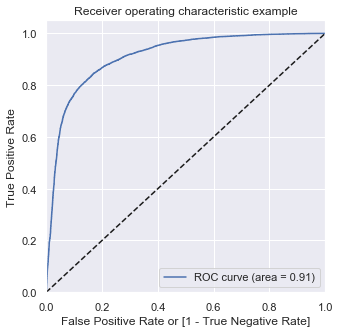

VIF------------->


Features  VIF
0       PC1  1.0
1       PC2  1.0
22     PC23  1.0
23     PC24  1.0
24     PC25  1.0
25     PC26  1.0
26     PC27  1.0
27     PC28  1.0
28     PC29  1.0
29     PC30  1.0
30     PC31  1.0
31     PC32  1.0
32     PC33  1.0
33     PC34  1.0
34     PC35  1.0
35     PC36  1.0
36     PC37  1.0
37     PC38  1.0
38     PC39  1.0
21     PC22  1.0
20     PC21  1.0
19     PC20  1.0
9      PC10  1.0
2       PC3  1.0
3       PC4  1.0
4       PC5  1.0
5       PC6  1.0
6       PC7  1.0
7       PC8  1.0
8       PC9  1.0
10     PC11  1.0
18     PC19  1.0
11     PC12  1.0
12     PC13  1.0
13     PC14  1.0
14     PC15  1.0
15     PC16  1.0
16     PC17  1.0
17     PC18  1.0
39     PC40  1.0

<Figure size 360x360 with 0 Axes>

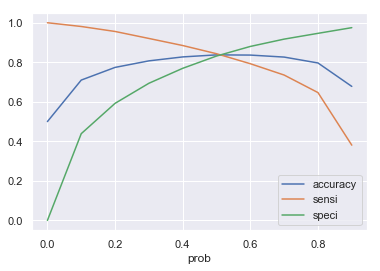

Result on Training Data
Confusion Matrix :
[[10142  2054]
 [ 1911 10285]]
accuracy score: 0.84 
sensitivity : 0.84
specificity :0.83
---------------


In [247]:
model = logistic_regression(df_X_pca_train,y_res,df_X_pca_test,y_test,list(df_X_pca_train.columns))

In [248]:
test=sm.add_constant(df_X_pca_test)
y_test=y_test.astype(int)
print(test.shape)
y_test_pred = model.predict(test)
y_test_pred_final=pd.DataFrame({'Churn':y_test.values, 'Churn_Prob': y_test_pred })
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final
model_performance(y_test_pred_final)

(5659, 41)
Confusion Matrix :
[[4321  856]
 [  81  401]]
accuracy score: 0.83 
sensitivity : 0.83
specificity :0.83


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                24392
Model:                            GLM   Df Residuals:                    24341
Model Family:                Binomial   Df Model:                           50
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9125.1
Date:                Mon, 19 Aug 2019   Deviance:                       18250.
Time:                        08:02:11   Pearson chi2:                 3.25e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2622      0.022    -11.854      0.000      -0.305      -0.219
PC1           -0.7926      0.019    -42.024      0.0

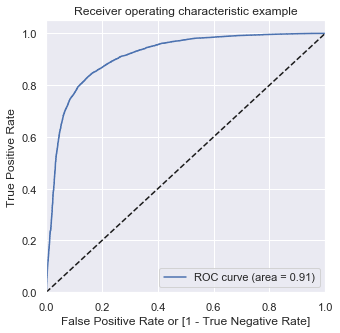

VIF------------->


In [ ]:
df_X_pca_train, df_X_pca_test=func_PCA(50,X_res,X_test)
model=logistic_regression(df_X_pca_train,y_res,df_X_pca_test,y_test,list(df_X_pca_train.columns))

In [ ]:
test=sm.add_constant(df_X_pca_test)
y_test=y_test.astype(int)
print(test.shape)
y_test_pred = model.predict(test)
y_test_pred_final=pd.DataFrame({'Churn':y_test.values, 'Churn_Prob': y_test_pred })
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final
model_performance(y_test_pred_final)

## Decision Tress

In [ ]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(X_res, y_res)

In [ ]:
# Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_default = dt_default.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_default))

print('AUC Score ' ,(round(metrics.roc_auc_score(y_test, y_pred_default),2)))

In [ ]:
# Printing confusion matrix and accuracy

print(accuracy_score(y_test,y_pred_default))
df=pd.DataFrame({'Churn':y_test, 'predicted':y_pred_default})
model_performance(df)

In [ ]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

# Putting features
features = list(telecom.columns[1:])
features

In [ ]:
# If you're on windows:
# Specifing path for dot file.
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin/'

In [ ]:
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(dt_default, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Tuning maximum depth method

In [ ]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
%time tree.fit(X_res, y_res)

Wall time: 3min 49s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(1, 40)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

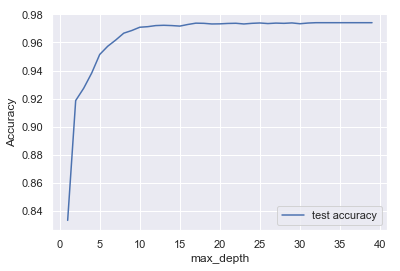

In [ ]:
# plotting accuracies with max_depth
plt.figure()
#plt.plot(scores["param_max_depth"], 
         #scores["mean_train_score"], 
         #label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Tunning min_sample_leaf

In [ ]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
%time tree.fit(X_res, y_res)

Wall time: 50.7 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fal

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.212159      0.048609         0.006184    9.772433e-04   
1       1.055977      0.032492         0.005386    7.981542e-04   
2       0.982373      0.014873         0.005187    3.994704e-04   
3       0.961629      0.014865         0.005985    5.223489e-07   
4       0.975591      0.039449         0.005386    4.888309e-04   

  param_min_samples_leaf                    params  split0_test_score  \
0                      5   {'min_samples_leaf': 5}           0.963115   
1                     25  {'min_samples_leaf': 25}           0.956352   
2                     45  {'min_samples_leaf': 45}           0.951025   
3                     65  {'min_samples_leaf': 65}           0.946721   
4                     85  {'min_samples_leaf': 85}           0.946721   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.974785           0.976220           0.971095           0.968635   
1           0.962075           0.967610           0.962075           0.963510   
2           0.957565           0.962075           0.953875           0.956745   
3           0.954285           0.957770           0.949774           0.953670   
4           0.951825           0.952645           0.948954           0.955310   

   mean_test_score  std_test_score  rank_test_score  
0         0.970769        0.004671                1  
1         0.962324        0.003609                2  
2         0.956256        0.003711                3  
3         0.952443        0.003825                4  
4         0.951091        0.002980                5

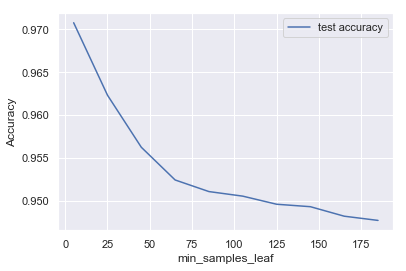

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
#plt.plot(scores["param_min_samples_leaf"], 
#         scores["mean_train_score"], 
#         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Tunning minimum sample leaf

In [ ]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
%time tree.fit(X_res, y_res)

Wall time: 52.4 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fal

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.264818      0.041084         0.005984    3.504023e-07   
1       1.118809      0.021588         0.005984    6.311282e-04   
2       1.074327      0.033152         0.006982    1.261427e-03   
3       1.015286      0.031589         0.005785    3.987554e-04   
4       0.972799      0.016684         0.005785    3.988986e-04   

  param_min_samples_leaf                    params  split0_test_score  \
0                      5   {'min_samples_leaf': 5}           0.963115   
1                     25  {'min_samples_leaf': 25}           0.956352   
2                     45  {'min_samples_leaf': 45}           0.951025   
3                     65  {'min_samples_leaf': 65}           0.946721   
4                     85  {'min_samples_leaf': 85}           0.946721   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.974785           0.976220           0.971095           0.968635   
1           0.962075           0.967610           0.962075           0.963510   
2           0.957565           0.962075           0.953875           0.956745   
3           0.954285           0.957770           0.949774           0.953670   
4           0.951825           0.952645           0.948954           0.955310   

   mean_test_score  std_test_score  rank_test_score  
0         0.970769        0.004671                1  
1         0.962324        0.003609                2  
2         0.956256        0.003711                3  
3         0.952443        0.003825                4  
4         0.951091        0.002980                5

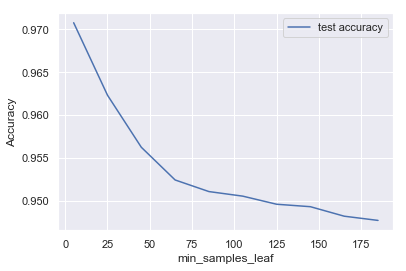

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
#plt.plot(scores["param_min_samples_leaf"], 
#         scores["mean_train_score"], 
#         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Tunning min_samples_split

In [ ]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fa

In [ ]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       1.171468      0.077883         0.003790        0.000746   
1       1.181841      0.069247         0.003790        0.000746   
2       1.187226      0.079875         0.003790        0.000399   
3       1.188622      0.081636         0.004389        0.000488   
4       1.207970      0.100969         0.003392        0.000488   

  param_min_samples_split                     params  split0_test_score  \
0                       5   {'min_samples_split': 5}           0.979561   
1                      25  {'min_samples_split': 25}           0.982967   
2                      45  {'min_samples_split': 45}           0.985617   
3                      65  {'min_samples_split': 65}           0.985995   
4                      85  {'min_samples_split': 85}           0.985995   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.978417           0.977281           0.984091           0.978788   
1           0.979553           0.979932           0.989394           0.982955   
2           0.980310           0.981825           0.988258           0.983333   
3           0.980689           0.982204           0.989015           0.985227   
4           0.981446           0.982961           0.989773           0.986364   

   mean_test_score  std_test_score  rank_test_score  
0         0.979627        0.002349               10  
1         0.982960        0.003526                9  
2         0.983869        0.002809                8  
3         0.984626        0.002928                7  
4         0.985307        0.002896                5

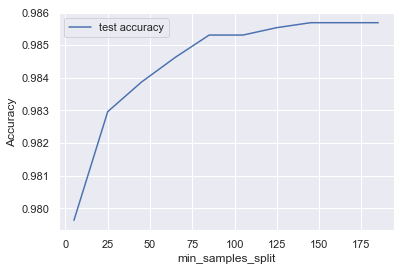

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
#plt.plot(scores["param_min_samples_split"], 
#         scores["mean_train_score"], 
#         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


### Finding optimum parameters

In [ ]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(10,100, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
%time grid_search.fit(X_res,y_res)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.4min finished


Wall time: 1min 25s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                      

In [ ]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.095272      0.018405         0.005585    4.888313e-04   
1        1.091083      0.008053         0.005785    3.992084e-04   
2        1.080910      0.011991         0.005984    6.309774e-04   
3        1.079514      0.011027         0.005585    4.890644e-04   
4        1.388487      0.014195         0.005586    4.891040e-04   
5        1.360363      0.016340         0.005984    6.315057e-04   
6        1.248462      0.010159         0.005785    7.466845e-04   
7        1.271201      0.046590         0.005386    4.887334e-04   
8        0.788093      0.038665         0.006184    1.934082e-03   
9        0.748598      0.004306         0.005586    4.885777e-04   
10       0.744809      0.005292         0.004987    3.234067e-07   
11       0.745207      0.004250         0.005586    4.889872e-04   
12       1.034833      0.018080         0.005785    3.992324e-04   
13       1.018477      0.007394         0.005785    7.467607e-04   
14       0.948065      0.011008         0.005785    3.991366e-04   
15       0.950060      0.010528         0.005385    4.885582e-04   

   param_criterion param_max_depth param_min_samples_leaf  \
0          entropy               5                     10   
1          entropy               5                     10   
2          entropy               5                     60   
3          entropy               5                     60   
4          entropy              10                     10   
5          entropy              10                     10   
6          entropy              10                     60   
7          entropy              10                     60   
8             gini               5                     10   
9             gini               5                     10   
10            gini               5                     60   
11            gini               5                     60   
12            gini              10                     10   
13            gini              10                     10   
14            gini              10                     60   
15            gini              10                     60   

   param_min_samples_split                                             params  \
0                       50  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
1                      100  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
2                       50  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
3                      100  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
4                       50  {'criterion': 'entropy', 'max_depth': 10, 'min...   
5                      100  {'criterion': 'entropy', 'max_depth': 10, 'min...   
6                       50  {'criterion': 'entropy', 'max_depth': 10, 'min...   
7                      100  {'criterion': 'entropy', 'max_depth': 10, 'min...   
8                       50  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
9                      100  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
10                      50  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
11                     100  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
12                      50  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   
13                     100  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   
14                      50  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   
15                     100  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   

    split0_test_score  split1_test_score  split2_test_score  \
0            0.943238           0.947724           0.948339   
1            0.943238           0.947724           0.948339   
2            0.942008           0.946494           0.946289   
3            0.942008           0.946494           0.946289   
4            0.958811           0.968225           0.969865   
5            0.952254           0.963715           0.

### finding optimal parameters

In [ ]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.9679403082978025
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


### Running model with optimal parameters

In [ ]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=10,
                                  min_samples_split=50)
%time clf_gini.fit(X_res, y_res)

Wall time: 1.3 s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [ ]:
# accuracy score
clf_gini.score(X_test,y_test)

0.9669552924544973

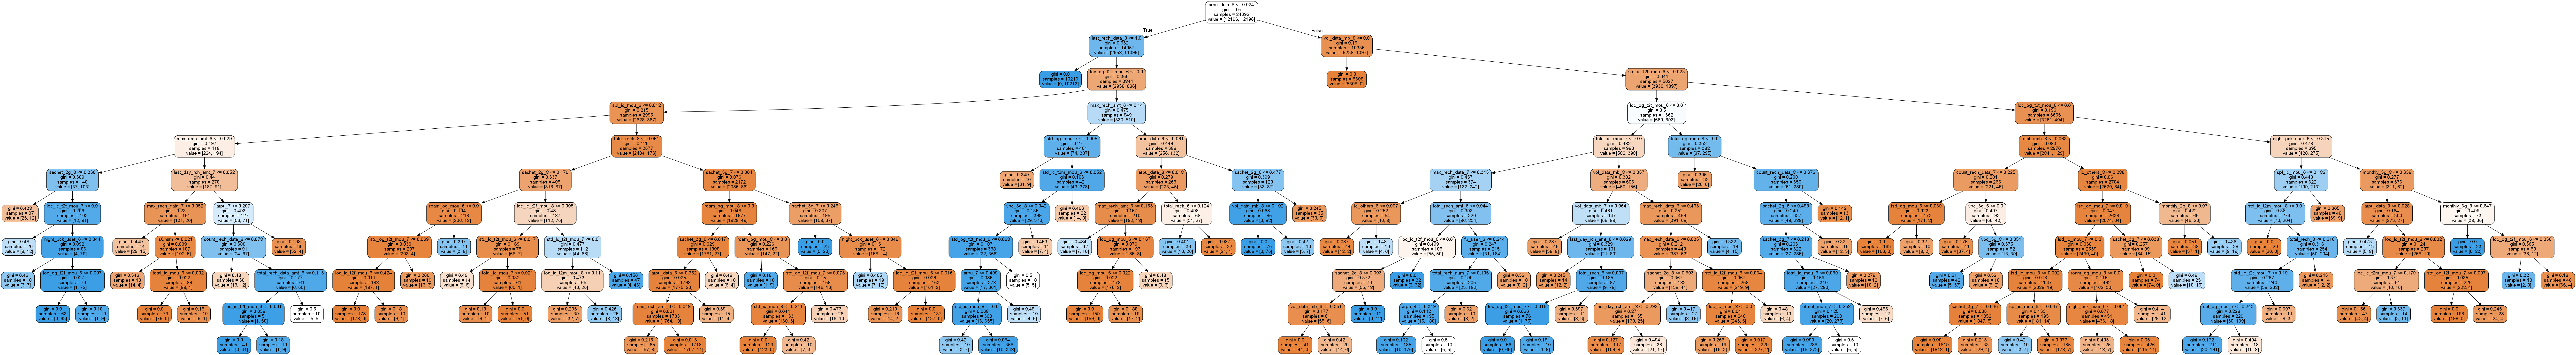

In [ ]:
# plotting the tree
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
# classification metrics
from sklearn.metrics import classification_report,confusion_matrix
y_pred = clf_gini.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5177
           1       0.77      0.88      0.82       482

    accuracy                           0.97      5659
   macro avg       0.88      0.93      0.90      5659
weighted avg       0.97      0.97      0.97      5659



In [ ]:
# confusion matrix
print('training data')
y_train_pred=clf_gini.predict(X_res)
df=pd.DataFrame({'Churn':y_res, 'predicted':y_train_pred})
model_performance(df)

print('test data')

df=pd.DataFrame({'Churn':y_test, 'predicted':y_pred})
model_performance(df)

training data
Confusion Matrix :
[[12024   172]
 [  324 11872]]
accuracy score: 0.98 
sensitivity : 0.97
specificity :0.99
test data
Confusion Matrix :
[[5049  128]
 [  59  423]]
accuracy score: 0.97 
sensitivity : 0.88
specificity :0.98


SVM

In [ ]:
%time model =SVM(df_X_pca_train,y_res)


Confusion Matrix :
[[10632  1564]
 [ 1246 10950]]
accuracy score: 0.88 
sensitivity : 0.9
specificity :0.87
Wall time: 49.9 s


In [ ]:
y_test=y_test.astype(int)
y_test_pred = model.predict(df_X_pca_test)
y_test_pred_final=pd.DataFrame({'Churn':y_test.values, 'Churn_Prob': y_test_pred })
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final
model_performance(y_test_pred_final)

Confusion Matrix :
[[4464  713]
 [ 105  377]]
accuracy score: 0.86 
sensitivity : 0.78
specificity :0.86


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  4.4min finished


The best test score is 0.9840559369224473 corresponding to hyperparameters {'C': 100, 'gamma': 0.1}
Wall time: 5min 7s


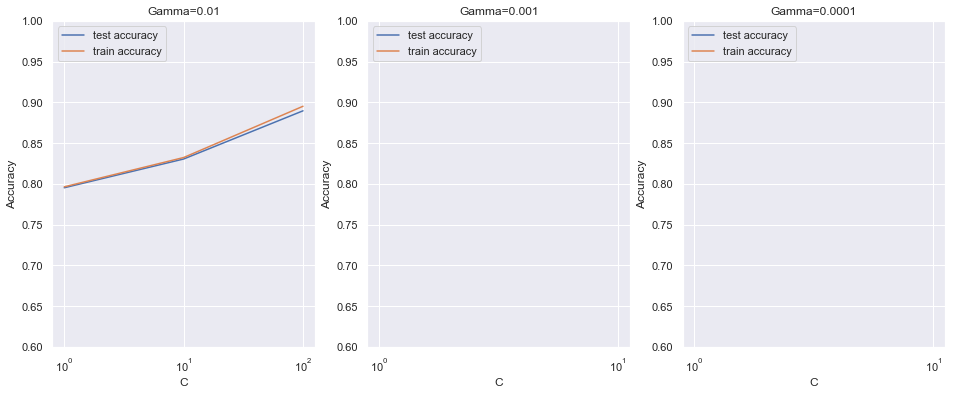

In [ ]:
%time svm_hyper_parameter_tuning(df_X_pca_train,y_res,n_split=3)

In [ ]:
%time model =SVM(df_X_pca_train,y_res, C=100, gamma = .1)
y_test=y_test.astype(int)
y_test_pred = model.predict(df_X_pca_test)
y_test_pred_final=pd.DataFrame({'Churn':y_test.values, 'Churn_Prob': y_test_pred })
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final
model_performance(y_test_pred_final)

Confusion Matrix :
[[10560  1636]
 [ 1186 11010]]
accuracy score: 0.88 
sensitivity : 0.9
specificity :0.87
Wall time: 50.2 s
Confusion Matrix :
[[4441  736]
 [ 101  381]]
accuracy score: 0.85 
sensitivity : 0.79
specificity :0.86


## Random forest

#### Running the model with default parameters

In [ ]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [ ]:
# fit
rfc.fit(X_res,y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Making predictions
predictions = rfc.predict(X_test)

In [ ]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5177
           1       0.95      0.85      0.90       482

    accuracy                           0.98      5659
   macro avg       0.97      0.92      0.94      5659
weighted avg       0.98      0.98      0.98      5659



In [ ]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[5154   23]
 [  72  410]]


In [ ]:
print(accuracy_score(y_test,predictions))



0.9832125817282206


### Tunning max_depth

In [ ]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_res, y_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.311168      0.007108         0.010378    8.091451e-04   
1       0.736630      0.015522         0.011769    3.991606e-04   
2       0.968610      0.016918         0.012966    5.560829e-07   
3       0.993942      0.030686         0.013570    4.932816e-04   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               2   {'max_depth': 2}           0.870082           0.896064   
1               7   {'max_depth': 7}           0.958402           0.971710   
2              12  {'max_depth': 12}           0.981762           0.990160   
3              17  {'max_depth': 17}           0.981352           0.991185   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           0.837843           0.889504           0.869824         0.872663   
1           0.970685           0.968635           0.968840         0.967653   
2           0.988725           0.987905           0.986880         0.987086   
3           0.990775           0.988930           0.990775         0.988603   

   std_test_score  rank_test_score  
0        0.020289                4  
1        0.004767                3  
2        0.002870                2  
3        0.003709                1

In [ ]:
pd.DataFrame(scores).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

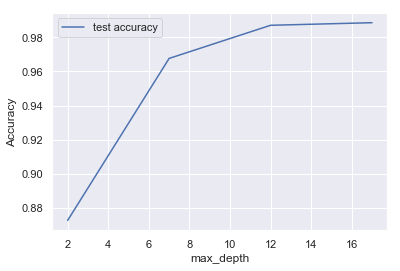

In [ ]:
# plotting accuracies with max_depth
plt.figure()
#plt.plot(scores["param_max_depth"], 
#         scores["mean_train_score"], 
#         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Tuning n_estimator

In [ ]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_res, y_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.768451      0.052358         0.056051        0.000747   
1      24.071046      0.334991         0.269081        0.024587   
2      42.823311      0.147109         0.466155        0.009283   
3      62.553963      1.092384         0.704323        0.090158   

  param_n_estimators                  params  split0_test_score  \
0                100   {'n_estimators': 100}           0.924385   
1                500   {'n_estimators': 500}           0.922951   
2                900   {'n_estimators': 900}           0.924385   
3               1300  {'n_estimators': 1300}           0.922336   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.934399           0.934809           0.936449           0.934604   
1           0.935629           0.931939           0.938089           0.936244   
2           0.932964           0.933989           0.934604           0.935834   
3           0.933169           0.933579           0.936244           0.935424   

   mean_test_score  std_test_score  rank_test_score  
0         0.932929        0.004334                2  
1         0.932970        0.005394                1  
2         0.932355        0.004093                3  
3         0.932150        0.005038                4

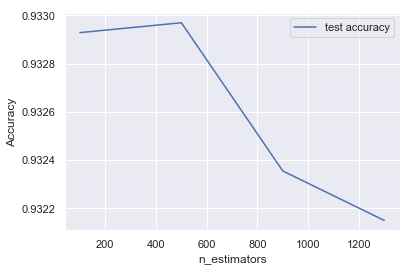

In [ ]:
# plotting accuracies with n_estimators
plt.figure()
#plt.plot(scores["param_n_estimators"], 
#         scores["mean_train_score"], 
#         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Tunning max_features

In [ ]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 3

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=4)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_res, y_res)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=4,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='w

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_features', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

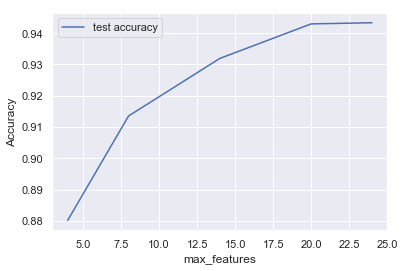

In [ ]:
# plotting accuracies with n_estimators
plt.figure()
#plt.plot(scores["param_n_estimators"], 
#         scores["mean_train_score"], 
#         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Tunning min_sample_leaf

In [ ]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_res, y_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.758898      0.024931         0.011969    4.264961e-07   
1       0.708496      0.036374         0.011974    6.308355e-04   
2       0.685766      0.022678         0.011569    4.890644e-04   
3       0.637496      0.027301         0.011968    6.310527e-04   
4       0.620142      0.010140         0.011576    4.934566e-04   

  param_min_samples_leaf                     params  split0_test_score  \
0                    100  {'min_samples_leaf': 100}           0.945902   
1                    150  {'min_samples_leaf': 150}           0.945902   
2                    200  {'min_samples_leaf': 200}           0.940574   
3                    250  {'min_samples_leaf': 250}           0.900820   
4                    300  {'min_samples_leaf': 300}           0.926025   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.956950           0.958180           0.953055           0.946289   
1           0.935834           0.933374           0.953875           0.943624   
2           0.929274           0.948339           0.937064           0.923534   
3           0.939319           0.935014           0.940754           0.933374   
4           0.901599           0.906109           0.921894           0.921279   

   mean_test_score  std_test_score  rank_test_score  
0         0.952074        0.005169                1  
1         0.942522        0.007347                2  
2         0.935758        0.008656                3  
3         0.929854        0.014769                4  
4         0.915382        0.009658                5

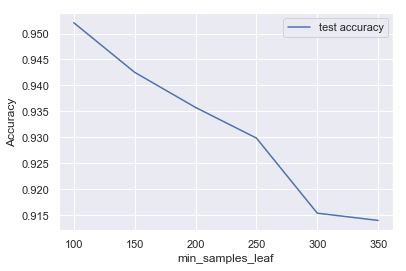

In [ ]:
# plotting accuracies with min_samples_leaf
plt.figure()
#plt.plot(scores["param_min_samples_leaf"], 
#         scores["mean_train_score"], 
#         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Tunning min_sample_split

In [ ]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_res, y_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.919741      0.049880         0.012766        0.000977   
1       0.908969      0.029997         0.012168        0.000399   
2       0.862693      0.055829         0.012572        0.001207   
3       0.845539      0.033433         0.011570        0.000488   
4       0.831577      0.034476         0.015372        0.006303   

  param_min_samples_split                      params  split0_test_score  \
0                     200  {'min_samples_split': 200}           0.952459   
1                     250  {'min_samples_split': 250}           0.952869   
2                     300  {'min_samples_split': 300}           0.945902   
3                     350  {'min_samples_split': 350}           0.954508   
4                     400  {'min_samples_split': 400}           0.950205   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.963510           0.963715           0.962690           0.963305   
1           0.963305           0.957975           0.955105           0.960435   
2           0.959205           0.959615           0.959205           0.961050   
3           0.963305           0.961870           0.960845           0.956335   
4           0.952030           0.955720           0.953260           0.957565   

   mean_test_score  std_test_score  rank_test_score  
0         0.961135        0.004352                1  
1         0.957937        0.003708                3  
2         0.956994        0.005589                4  
3         0.959372        0.003369                2  
4         0.953755        0.002615                5

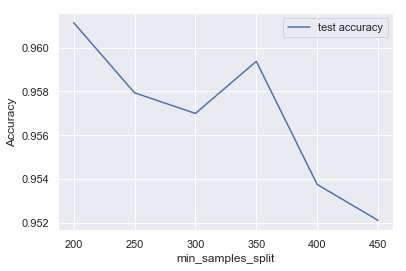

In [ ]:
# plotting accuracies with min_samples_split
plt.figure()
#plt.plot(scores["param_min_samples_split"], 
#         scores["mean_train_score"], 
#         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
### Grid Search to find optimal parameters
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_res, y_res)

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 199.9min


In [ ]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

In [ ]:
# Running model with best feature

# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=8,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=200)

# fit
rfc.fit(X_train,y_train)

# predict
predictions = rfc.predict(X_test)

# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predictions))



In [ ]:
print('training data')
y_train_pred=rfc.predict(X_res)
df=pd.DataFrame({'Churn':y_res, 'predicted':y_train_pred})
model_performance(df)
print('------'*3)
print('test data')
df=pd.DataFrame({'Churn':y_test, 'predicted':predictions})
model_performance(df)

XG Boost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

In [ ]:
# adaboost classifier with max 600 decision trees of depth=2
# learning_rate/shrinkage=1.5

# base estimator
tree = DecisionTreeClassifier(max_depth=2)

# adaboost with the tree as base estimator
adaboost_model_1 = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=600,
    learning_rate=0.2,
    algorithm="SAMME")
# fit
adaboost_model_1.fit(df_X_pca_train,y_res)
predictions = adaboost_model_1.predict_proba(df_X_pca_test)
metrics.roc_auc_score(y_test, predictions[:,1])

# df_X_pca_train,y_res,df_X_pca_test,y_test

In [ ]:
print('Training')
y_train_pred = adaboost_model_1.predict(df_X_pca_train)
y_train_pred_final=pd.DataFrame({'Churn':y_res, 'predicted': y_train_pred })
model_performance(y_train_pred_final)
print('-----'*4)
print('Test')
y_test_pred = adaboost_model_1.predict(df_X_pca_test)
y_test_pred_final=pd.DataFrame({'Churn':y_test, 'predicted': y_test_pred })
model_performance(y_test_pred_final)

XGBoost

In [ ]:
# fit model on training data with default hyperparameters
model = XGBClassifier(learning_rate=0.1, _estimator=1000,max_depth=4,min_child_weight=6 ,gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
%time model.fit(df_X_pca_train,y_res)
y_pred = model.predict_proba(df_X_pca_test)
# y_pred[:10]
# evaluate predictions
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

In [ ]:
# AUC: 87.29%

In [ ]:
print('Training')
y_train_pred = model.predict(df_X_pca_train)
y_train_pred_final=pd.DataFrame({'Churn':y_res, 'predicted': y_train_pred })
model_performance(y_train_pred_final)
print('-----'*4)
print('Test')
print("AUC: %.2f%%" % (roc * 100.0))
y_test_pred = model.predict(df_X_pca_test)
y_test_pred_final=pd.DataFrame({'Churn':y_test, 'predicted': y_test_pred })
model_performance(y_test_pred_final)

#### Hyperparameter Tuning for XGBoost

Why is fine-tuning key? Because if you have big datasets, and you run a naive grid search on 5 different parameters and having for each of them 5 possible values, then you’ll have 5⁵ =3,125 iterations to go. If one iteration takes 10 minutes to run, you’ll have more than 21 days to wait before getting your parameters (I don’t talk about Python crashing, without letting you know, and you waiting too long before realizing it).

In [ ]:
eval_set = [(df_X_pca_train, y_res), (df_X_pca_test, y_test)]
eval_metric = ["auc","error"]
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 1,
                      objective='binary:logistic',
                      n_estimators=250, 
                      reg_alpha = 0.3,
                      max_depth=6, 
                      gamma=8)
%time model.fit(df_X_pca_train, y_res, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [ ]:
print('Training')
y_train_pred = model.predict(df_X_pca_train)
y_train_pred_final=pd.DataFrame({'Churn':y_res, 'predicted': y_train_pred })
model_performance(y_train_pred_final)
print('-----'*4)
print('Test')
print("AUC: %.2f%%" % (roc * 100.0))
y_test_pred = model.predict(df_X_pca_test)
y_test_pred_final=pd.DataFrame({'Churn':y_test, 'predicted': y_test_pred })
model_performance(y_test_pred_final)

## Conclusion

The important features which are determining the churn in customers based on ouput of Logistic Regression and Decision Tree:
1. arpu_8 and arpu_data_8
2. std_og_t2f_mou_8   
3. total_og_mou_8     
4. loc_ic_mou_7       
5. loc_ic_mou_8       
6. std_ic_t2f_mou_8   
7. spl_ic_mou_8       
8. last_day_rch_amt_8 
9. monthly_2g_8       
10. sachet_2g_8        
12. monthly_3g_8       
13. vol_data_mb_8      

### Model Performance
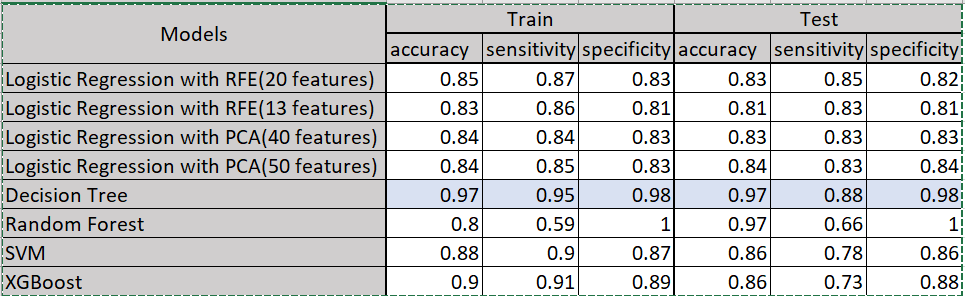

## Model Selection
We see that Decision Tree and Random Forest gives a better result in term of sensitivity and accuracy. 
We want to predict the churn cases accurately, while not compromising calling non-churn as churn
We are more focussed on Sensitivity as we are capturing maximum of positive cases.
We propose our Decision Tree as final model as we are predicting 88% Churn cases correctly which is highest in all the models we have tried.